# Equivalence trips to paths

the notebook should run without errors (check!)

TOC:

[Part 1: Trips](#part-1-trips)
- [1.1 Preformat trips](#1.1-preformat-trips)

[Part 2: Paths](#part-2-paths)
- [2.1 Preformat paths](#2.1-preformat-paths)

[Part 3: Remove un-localisable trips](#part-3-remove-un-localisable-trips)

[Part 4: Construct an equivalence between stations in MobA and stations in MMX](#part-4-construct-an-equivalence-between-stations-in-moba-and-stations-in-mmx)
- [4.1 Build station_to_NUTS dictionary](#4.1-build-station_to_nuts-dictionary)
- [4.2 Build the NUTS_to_MMX_train_station dictionary](#4.2-build-the-nuts_to_mmx_train_station-dictionary)
- [4.3 Join the two dictionaries](#4.3-join-the-two-dictionaries)

[Part 5: To how many trips can I assign a path?](#part-5-to-how-many-trips-can-i-assign-a-path)

[Part 6: Assign paths to trips](#part-6-assign-paths-to-trips)
- [6.1 Read and format the necessary files](#6.1-read-and-format-the-necessary-files)
- [6.2 Assign path with costs to trips (best assignation so far)](#6.2-assign-path-with-costs-to-trips-best-assignation-so-far)
- [6.3 Bis re-assignation](#6.3-bis-re-assignation)
- [6.4 Separate the itineraries in unique and repeated ones (SKIP!)](#6.4-separate-the-itineraries-in-unique-and-repeated-ones-skip)
- [6.5 Merge trips with itineraries (SKIP!)](#6.5-merge-trips-with-itineraries-skip)

[Part 7: A bit of analysis of the assignation](#part-7-a-bit-of-analysis-of-the-assignation)

[Part 8: First Logit Model calibration](#part-8-first-logit-model-calibration)

[Part 9: Analysis of the calibration](#part-9-analysis-of-the-calibration)

[Part 10: Let's see what happens in some other regions](#part-10-let's-see-what-happens-in-some-other-regions)

[Part 11: Logit Model calibration in two times](#part-11-logit-model-calibration-in-two-times)


In [1]:
# libraries to import
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ast import literal_eval
from typing import Dict
import os
print(os.getcwd())
os.chdir(r"C:\Users\LMENENDEZ\GitHub\MultiModX")
print(os.getcwd())
pd.set_option('display.max_columns', None)

c:\Users\LMENENDEZ\GitHub\MultiModX\notebooks
C:\Users\LMENENDEZ\GitHub\MultiModX


In [2]:
%load_ext autoreload

In [3]:
%autoreload
from strategic_evaluator.logit_model import *

## Part 1: Trips

In [4]:
# Trips during the week 22/09/2022 28/09/2022 (thursday to thursday)
# the day of study selected was Friday to put the air layer under pressure
all_trips = pd.read_csv(
    r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\Matrices MITMA\with_archetypes\20220922_28_trip_matrix_arc_pt_processed.csv.gz",
    compression="gzip",
    sep="|"
)

In [5]:
#Here there is no trip id but later trip id appears all the time
trips = all_trips[all_trips["date"] == 20220923].reset_index(drop=True).rename(columns={"origin_nut": "origin", "destination_nut": "destination"})
trips.head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced
0,20220923,P00,01002,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,NF,O,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*01002*01002*None*train_13121*00-01*road*No...,other,ES,2_48,4801303,2_48,I01_[10000-15000),A01_[25-45),male,passenger,False,4.135,139.516,1.0,0.000000,0.000000,2.067500,2.067500,0.000000,0.000000,3,road-train-road,train_13121-train_13200,train_13121,train_13200,national,2,1,0,train_13121-train_13200,train_13106,train_13200
1,20220923,P00,01009_AM,ES211,Álava,31010_AM,ES220,Navarra,NaN,NaN,O,H,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,ES,2_31,31010_AM,2_31,I01_[10000-15000),A01_[25-45),male,passenger,False,5.191,69.312,1.0,3.707857,0.000000,0.000000,0.494381,0.000000,0.988762,3,road-train-road,train_11213-train_11300,train_11213,train_11300,national,2,1,0,train_11213-train_11300,train_13106,train_11300
2,20220923,P00,01009_AM,ES211,Álava,abroad_208,abroad,abroad,NaN,ground_Fra_08,NF,NF,abroad,D05_[50000-inf),01-02,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,FR,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,1.599,309.588,1.0,0.888333,0.399750,0.142133,0.071067,0.062183,0.035533,3,road-train-road,train_11213-train_11600,train_11213,train_11600,international_D,2,1,0,train_11213-train_11600,train_11208,train_11511
3,20220923,P00,01036,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,H,O,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01036*01036*None*train_13106*00-01*road*No...,other,ES,2_01,01036,2_48,I02_[15000-inf),A02_[45-65),female,passenger,False,6.236,139.477,1.0,3.118000,0.000000,0.779500,1.559000,0.779500,0.000000,3,road-train-road,train_13106-train_13200,train_13106,train_13200,national,2,1,0,train_13106-train_13200,train_13106,train_13200
4,20220923,P00,0105902,ES211,Álava,09219,ES412,Burgos,NaN,NaN,O,NF,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*0105902*0105901*None*train_11208*00-01*roa...,other,ES,2_01,0105904,2_01,I02_[15000-inf),A02_[45-65),male,passenger,False,4.215,155.813,1.0,3.417568,0.113919,0.227838,0.227838,0.227838,0.000000,3,road-train-road,train_11208-train_11200,train_11208,train_11200,national,2,1,0,train_11208-train_11200,train_11208,train_11200


In [6]:
#associates each airport to the corresponding new NUTS
airports_to_NUTS={"airport_LPA":("ES705","Gran Canaria"),
                 "airport_FUE":("ES704","Fuerteventura"),
                 "airport_ACE":("ES708","Lanzarote"),
                 "airport_TFS":("ES709","Tenerife"),
                 "airport_TFN":("ES709","Tenerife"),
                 "airport_GMZ":("ES709","Tenerife"),
                 "airport_SPC":("ES707","La Palma"),
                 "airport_VDE":("ES703","El Hierro"),
                 "airport_PMI":("ES532","Mallorca"),
                 "airport_IBZ":("ES531","Eivissa i Formentera"),
                 "airport_MAH":("ES533","Menorca")}

In [7]:
def format_trips(trips: pd.DataFrame, airports_to_NUTS: dict):
    # Filter trips (only those without "abroad" as origin or destination)
    trips = trips[~((trips["origin"] == "abroad") | (trips["destination"] == "abroad"))].copy()

    # Modify 'mode_tp' column: replacing modes with specific terminology
    trips.loc[:, "mode_tp"] = (
        trips["mode_sequence"]
        .str.replace("bus", "road")  # replace bus to road (some people can reach infrastructure by bus)
        .str.replace("plane", "air")  # use nomenclature of the offer data
        .str.replace("train", "rail")
    )

    # Remove "road" from the 'mode_tp' column
    trips.loc[:, "mode_tp"] = trips["mode_tp"].apply(
        lambda row: [mode for mode in row.split("-") if mode != "road"]
    )  # remove "road" (it will be considered like access time)

    # Only consider trips that do not contain "ship"
    trips = trips[~trips["mode_tp"].apply(lambda x: "ship" in x)]

    # Change aggregated island NUTS to dis-aggregated NUTS
    for key in airports_to_NUTS.keys():
        trips.loc[trips["start_node"] == key, ["origin", "origin_name"]] = [
            airports_to_NUTS[key][0],
            airports_to_NUTS[key][1]
        ]  # change start node
        trips.loc[trips["end_node"] == key, ["destination", "destination_name"]] = [
            airports_to_NUTS[key][0],
            airports_to_NUTS[key][1]
        ]  # change destination node

    return trips

### 1.1 Preformat trips 

Trips now account for the new NUTS and have an extra column named mode_tp that accounts for the combination of trains and planes taken during the day

In [8]:
trips=format_trips(trips,airports_to_NUTS)

In [9]:
trips

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp
0,20220923,P00,01002,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,NF,O,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*01002*01002*None*train_13121*00-01*road*No...,other,ES,2_48,4801303,2_48,I01_[10000-15000),A01_[25-45),male,passenger,False,4.135,139.516,1.0,0.000000,0.000000,2.067500,2.067500,0.000000,0.000000,3,road-train-road,train_13121-train_13200,train_13121,train_13200,national,2,1,0,train_13121-train_13200,train_13106,train_13200,[rail]
1,20220923,P00,01009_AM,ES211,Álava,31010_AM,ES220,Navarra,NaN,NaN,O,H,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01009_AM*01009_AM*None*train_11213*00-01*r...,other,ES,2_31,31010_AM,2_31,I01_[10000-15000),A01_[25-45),male,passenger,False,5.191,69.312,1.0,3.707857,0.000000,0.000000,0.494381,0.000000,0.988762,3,road-train-road,train_11213-train_11300,train_11213,train_11300,national,2,1,0,train_11213-train_11300,train_13106,train_11300,[rail]
3,20220923,P00,01036,ES211,Álava,4802006,ES213,Vizcaya,NaN,NaN,H,O,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*01036*01036*None*train_13106*00-01*road*No...,other,ES,2_01,01036,2_48,I02_[15000-inf),A02_[45-65),female,passenger,False,6.236,139.477,1.0,3.118000,0.000000,0.779500,1.559000,0.779500,0.000000,3,road-train-road,train_13106-train_13200,train_13106,train_13200,national,2,1,0,train_13106-train_13200,train_13106,train_13200,[rail]
4,20220923,P00,0105902,ES211,Álava,09219,ES412,Burgos,NaN,NaN,O,NF,D04_[10000-50000),D04_[10000-50000),01-02,train,conv_unknown,P00*0105902*0105901*None*train_11208*00-01*roa...,other,ES,2_01,0105904,2_01,I02_[15000-inf),A02_[45-65),male,passenger,False,4.215,155.813,1.0,3.417568,0.113919,0.227838,0.227838,0.227838,0.000000,3,road-train-road,train_11208-train_11200,train_11208,train_11200,national,2,1,0,train_11208-train_11200,train_11208,train_11200,[rail]
5,20220923,P00,0105902,ES211,Álava,09219,ES412,Burgos,NaN,NaN,W,H,D04_[10000-50000),D04_[10000-50000),00-01,train,conv_unknown,P00*0105902*0105901*None*train_11208*00-01*roa...,other,ES,2_09,09219,2_09,I01_[10000-15000),A02_[45-65),male,passenger,False,3.574,133.590,1.0,2.757086,0.000000,0.204229,0.102114,0.000000,0.510571,3,road-train-road,train_11208-train_11200,train_11208,train_11200,national,2,1,0,train_11208-train_11200,train_11208,train_11200,[rail]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227596,20220923,P23,5029709,ES243,Zaragoza,44056_AM,ES242,Teruel,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),01-02,train,conv_unknown,P23*5029709*5029703*None*train_70806*00-01*roa...,other,ES,2_22,22048,2_22,I01_[10000-15000),A02_[45-65),female,passenger,False,3.468,630.518,1.0,2.813660,0.007270,0.029082,0.152679,0.247195,0.218113,3,road-train-road,train_70806-train_67103,train_70806,train_67103,national,2,1,0,train_70806-train_67103,train_4040,train_71201,[rail]
227597,20220923,P23,5029709,ES243,Zaragoza,44056_AM,ES242,Teruel,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),01-02,train,conv_unknown,P23*5029709*5029703*None*train_70806*00-01*roa...,other,ES,2_22,22048,2_22,I01_[10000-15000),A03_[65-100),female,passenger,False,4.735,839.483,1.0,3.809162,0.026453,0.052905,0.238073,0.317430,0.290978,3,road-train-road,train_70806-train_67103,train_70806,train_67103,national,2,1,0,trai

In [10]:
trips["mode_tp"].value_counts()

mode_tp
[rail]                102692
[air]                  25613
[rail, rail]            2284
[air, air]               711
[air, rail]              188
[rail, air]              114
[rail, rail, rail]        19
[air, air, air]            8
[rail, air, rail]          2
[air, air, rail]           1
[air, rail, rail]          1
Name: count, dtype: int64

In order to assign trips with the correct path we need to know the duration of the trip better. The following function adds two column that account for the minimum duration of the trip and the maximum duration of the trip

In [11]:
# Function to parse the trip_duration and calculate min and max durations
def parse_duration(row):
    # Remove the square brackets and split the string by '-'
    duration_str = row['duration'][:]  # Removing '[' and ']'
    min_val, max_val = duration_str.split('-')

    # Convert the values to minutes, handling 'inf'
    if min_val == 'inf':
        min_duration = float('inf')
    else:
        min_duration = int(min_val) * 60  # Convert to minutes

    if max_val == 'inf':
        max_duration = float('inf')
    else:
        max_duration = int(max_val) * 60  # Convert to minutes

    return pd.Series([min_duration, max_duration])


In [12]:
# create two new columns named duration_min and duration_max
trips[['duration_min', 'duration_max']] = trips.apply(parse_duration, axis=1)

There are a few trips that are done in Cercanías that we should remove

stations that I want to remove:
- In the province of Guadalajara:
    - Guadalajara: train_70200
    - Azuquecas: train_70105
    - Meco: train_70104
- In the province of Madrid:
    - Alcalá de Henares Universidad: train_70107
    - Alcalá de Henares: train_70103
    - Torrejón de Ardóz: train_70102
    - La Garena: train_70111
    - Coslada: train_70108
    - San fernando de Henares: train_70101

In [13]:
# # Lists of cercanias stations that screw the assignation
# stations_madrid = ["train_70101",'train_70102', 'train_70103',"train_70107","train_70108","train_70111"] # corresponding to san fernando de henares, torrejon de ardoz, alcala de henares, the university of alcala, and la garena
# stations_guadalajara = ["train_70104" ,'train_70105', 'train_70200'] # corresponding to meco, azuquecas and guadalajara

# # Define function to check if a row should be eliminated
# def eliminate_cercanias(node_sequence):
#     # Split the string into individual stations
#     stations = node_sequence.split('-')
#     start, end = stations[0], stations[-1]  # Get the first and last station
    
#     # Check elimination conditions
#     return ((start in stations_madrid and end in stations_guadalajara) or
#             (start in stations_guadalajara and end in stations_madrid))

In [14]:
# # Apply the function to filter out rows
# trips = trips[~trips['node_sequence_reduced'].apply(eliminate_cercanias)]

other option: remove all trips made by train from guadalajara to Madrid since there is a Cercanías line

In [15]:
trips=trips[~(((trips["origin"]=="ES424")&(trips["destination"]=="ES300"))|((trips["origin"]=="ES300")&(trips["destination"]=="ES424")))]

## PART 2: Paths

**This part could be skipped now since I did not use paths in the end**

There are two types of paths, those limited to one connection and those limited to two connections. Two connections might be more realistic but in reality there are only few people that do this kind of trip

In [16]:
potential_paths_1_connection = pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline\paths_itineraries\potential_paths_0.csv")
potential_paths_1_connection.head()

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,origin_0,destination_0,provider_0,alliance_0,mode_0,travel_time_0,cost_0,emissions_0,origin_1,destination_1,provider_1,alliance_1,mode_1,travel_time_1,mct_time_0_1,cost_1,emissions_1
0,ES111,ES112,0,1,"['007131412', '007131400']",170.0,5.07,1.59,NaN,1,rail,43.0,101.0,007131412,007131400,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,26.0,5.07,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ES111,ES112,1,1,"['007131412', '007120300']",285.0,10.89,3.41,NaN,1,rail,43.0,74.0,007131412,007120300,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,168.0,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ES111,ES112,2,0,['007131400'],162.0,NaN,NaN,NaN,0,none,61.0,101.0,007131400,007131400,NaN,NaN,rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ES111,ES112,3,2,"['007131412', '007122100', '007120300']",231.0,14.45,4.52,NaN,1,rail,43.0,74.0,007131412,007122100,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,64.0,11.09,3.47,007122100,007120300,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,40.0,10.0,3.36,1.05
4,ES111,ES112,4,0,['LEST'],265.0,NaN,NaN,NaN,0,none,144.0,121.0,LEST,LEST,NaN,NaN,air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
potential_paths_2_connections = pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline_2_connections\paths_itineraries\potential_paths_0.csv")
potential_paths_2_connections.head()

,origin,destination,option,nservices,path,total_travel_time,total_cost,total_emissions,total_waiting_time,nmodes,journey_type,access_time,egress_time,origin_0,destination_0,provider_0,alliance_0,mode_0,travel_time_0,cost_0,emissions_0,origin_1,destination_1,provider_1,alliance_1,mode_1,travel_time_1,mct_time_0_1,cost_1,emissions_1,origin_2,destination_2,provider_2,alliance_2,mode_2,travel_time_2,mct_time_1_2,cost_2,emissions_2
0,ES111,ES112,0,1,"['007131412', '007131400']",170.0,5.07,1.59,NaN,1,rail,43.0,101.0,007131412,007131400,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,26.0,5.07,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ES111,ES112,1,1,"['007131412', '007120300']",285.0,10.89,3.41,NaN,1,rail,43.0,74.0,007131412,007120300,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,168.0,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ES111,ES112,2,0,['007131400'],162.0,NaN,NaN,NaN,0,none,61.0,101.0,007131400,007131400,NaN,NaN,rail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ES111,ES112,3,2,"['007131412', '007122100', '007120300']",231.0,14.45,4.52,NaN,1,rail,43.0,74.0,007131412,007122100,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,64.0,11.09,3.47,007122100,007120300,"RENFE VIAJEROS, S.A","RENFE VIAJEROS, S.A",rail,40.0,10.0,3.36,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ES111,ES112,4,0,['LEST'],265.0,NaN,NaN,NaN,0,none,144.0,121.0,LEST,LEST,NaN,NaN,air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1 Preformat paths
main tasks: remove the paths that have 0 modes (are only egress or access) and add the corresponding mode_tp column

In [18]:
def format_paths(paths: pd.DataFrame):
    # Create a copy of the filtered DataFrame to avoid potential views
    paths = paths[paths["nmodes"] != 0].copy() # removes trips that are only access and egress
    
    # Select the columns to iterate through
    mode_columns = [col for col in paths.columns if col.startswith("mode_")]
    
    # Safely assign the new 'mode_tp' column using .loc
    paths.loc[:, "mode_tp"] = paths.apply(
        lambda row: [row[col] for col in mode_columns if str(row[col]) != "nan"],
        axis=1
    )
    return paths

In [19]:
potential_paths_1_connection=format_paths(potential_paths_1_connection)
potential_paths_2_connections=format_paths(potential_paths_2_connections)

In [20]:
potential_paths_2_connections["mode_tp"].value_counts()

mode_tp
[rail, rail, rail]    85958
[rail, rail, air]     28608
[air, rail, rail]     23781
[air, air, air]       20351
[rail, rail]          18264
[air, air]            16343
[rail, air]           11034
[rail, air, air]       9061
[air, rail, air]       8602
[air, rail]            6542
[air, air, rail]       4937
[air]                  4671
[rail]                 2392
[rail, air, rail]      1549
Name: count, dtype: int64

## Part 3: Remove un-localisable trips

The trips start, end and go through many more stations (and perhaps airports) than the stations considered in MultiModX. Hence we have to assign a MMX station to all the stations that appear in the trips. But to do so we have to change the format of the stations first. 

In [21]:
# location of "ALL" train stops given by UiC
# However this list is still incomplete
stops_loc=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\infrastructure\rail_info\stops.txt").astype(str) # everything is a string here to match other formatting
stops_loc["stop_id"] = stops_loc["stop_id"].apply(lambda x: "00" + x) #to make they start with 00

In [22]:
#finds weird stations
def find_weird_stations(node_sequence,stops_loc):
    weird_stations=[]
    nodes = node_sequence.split("-")
    for node in nodes:
        if node.startswith("train_"):
            station_id=node.split("_")[1]
            if not station_id.isdigit():
                weird_stations.append(station_id)
            else:
                station_id_modified_1 = f"0071{int(station_id):05d}"
                station_id_modified_2 = f"0087{int(station_id):05d}"
                station_id_modified_3 = f"0094{int(station_id):05d}"
                if any(station_id in stops_loc["stop_id"].values for station_id in [station_id_modified_1, station_id_modified_2, station_id_modified_3]):
                    pass
                else:
                    weird_stations.append(station_id)
    return weird_stations

In [23]:
trips["weird_stations"] = trips["node_sequence_reduced"].apply(
    lambda x: find_weird_stations(x, stops_loc))

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_4148\570635083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips["weird_stations"] = trips["node_sequence_reduced"].apply(


In [24]:
# Assuming the "weird_stations" column contains lists
# Flatten the lists into one combined list
all_weird_stations = trips["weird_stations"].explode().dropna()

# Extract unique values
unique_weird_stations = all_weird_stations.unique()

# Convert back to a list if needed
unique_weird_stations = list(unique_weird_stations)
# converts this list into Moba format
unique_weird_stations_modified=[ "train_"+ station for station in unique_weird_stations] 

In [25]:
len(unique_weird_stations)

382

In [26]:
# This is the total number of trips that contain at least one weird station
weird_trips_num= trips[trips["weird_stations"].apply(lambda x: len(x) > 0)]["trips"].sum()
weird_trips_num

np.float64(41335.704)

In [27]:
# This is the number of trips that do not contain a weird station
normal_trips_num= trips[trips["weird_stations"].apply(lambda x: len(x) == 0)]["trips"].sum()
normal_trips_num

np.float64(448598.23399999994)

In [28]:
percent_normal_trips=normal_trips_num/trips["trips"].sum()*100
percent_normal_trips

np.float64(91.56300456164766)

Only 8 percent of all trips contain one of these non-localisable stations but they are a non-negligible part of the total

In [29]:
# read files with information about ALL stations considered by MobA
MobA_stations_coord=gpd.read_file(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\oferta_transporte\train_stations\train_stations.shp")

In [30]:
# identifies all the un-localisable stations
nowhere_stations=set(unique_weird_stations_modified)-set(MobA_stations_coord["ID"])
print(f"there are {len(nowhere_stations)} stations that are not in the data provided by MobA but appear in the trips dataframe")

there are 197 stations that are not in the data provided by MobA but appear in the trips dataframe


In [31]:
weird_trips_num= trips[trips["node_sequence_reduced"].apply(lambda x: any(station in x for station in nowhere_stations))]["trips"].sum()
print(f"there are in total {weird_trips_num} unlocalisable trips, i.e., {weird_trips_num/trips["trips"].sum()*100:.2f}% of the total")

there are in total 8681.27 unlocalisable trips, i.e., 1.77% of the total


We remove these weird trips from the total number of trips. Most of the removed trips come from Vizcaya (ES213) or arrive to Burgos (ES412). Keep this in mind for the calibration of the model.

In [32]:
trips = trips[~trips["node_sequence_reduced"].apply(lambda x: any(station in x for station in nowhere_stations))]

## Part 4: Construct an equivalence between stations in MobA and stations in MMX 

In [33]:
# coordinates, geometry and other properties of all NUTS (in Europe?)
NUTS_coord=gpd.read_file(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP4 Performance Assessment Solution\Demand data\nuts3_2003_geom_10.gpkg")

### 4.1 Build station_to_NUTS dictionary
contains all stations from MobA and their origin NUTS

In [34]:
# align coordinate reference system (crs)
NUTS_coord = NUTS_coord.to_crs(MobA_stations_coord.crs)

# Perform a spatial join to find which NUTS region each station belongs to
spatial_join = gpd.sjoin(MobA_stations_coord, NUTS_coord, how="left", predicate="within")

# Construct the dictionary
station_to_NUTS = dict(zip(spatial_join["ID"], spatial_join["geocode"]))

In [35]:
# list of stations considered in MMX
train_stations_considered=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\infrastructure\rail_info\rail_stations_considered_GTFS_2022v0.1.csv").astype(str)
train_stations_considered["stop_id"] = train_stations_considered["stop_id"].apply(lambda x: "00" + x) #to make they start with 00

In [36]:
#format train_station considered
def format_train_stations_considered(train_stations_considered: pd.DataFrame,station_to_nuts: Dict):
    train_stations_considered["modified_id"]=train_stations_considered["stop_id"].apply(lambda x : "train_" + str(x)[4:])
    train_stations_considered['NUTS'] = train_stations_considered['modified_id'].map(station_to_nuts)
    return train_stations_considered

In [37]:
train_stations_considered=format_train_stations_considered(train_stations_considered,station_to_NUTS)

In [38]:
train_stations_considered

,stop_id,modified_id,NUTS
0,007102002,train_02002,ES613
1,007102003,train_02003,ES617
2,007102030,train_02030,ES617
3,007103100,train_03100,ES616
4,007103208,train_03208,ES423
...,...,...,...
85,007181202,train_81202,ES220
86,007182100,train_82100,ES417
87,007192102,train_92102,ES425
88,007167200,train_67200,ES242


### 4.2 Build the NUTS_to_MMX_train_station dictionary

contains the origin NUTS and its associated MMX station

In [39]:
# build second dictionary
NUTS_to_MMX_train_station={}
for nuts, station in zip(train_stations_considered["NUTS"], train_stations_considered["stop_id"]):
    if nuts in NUTS_to_MMX_train_station:
        NUTS_to_MMX_train_station[nuts].append(station)
    else:
        NUTS_to_MMX_train_station[nuts]=[station]

### 4.3 Join the two dictionaries
to generate an equivalence of MobA stations and MMX stations

In [40]:
station_to_station_MMX = {}

for station, nuts_code in station_to_NUTS.items():
    # Get the value from nuts_to_train_stations_considered using the nuts_code
    if nuts_code in NUTS_to_MMX_train_station:
        station_to_station_MMX[station] = NUTS_to_MMX_train_station[nuts_code]

## Part 5: To how many trips can I assign a path?

Info: I have checked how many trips have a node sequence reduced that corresponds to a path in the potential_path documents. The goal is to assess how many trips are directly usable to calibrate the logit model.

In the future I will look onto how to maximise this number.

In [41]:
# construct a dictionary with the equivalence between IATA and ICAO codes
airports=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\infrastructure\airports_info\IATA_ICAO_Airport_codes_v1.3.csv")
airports["ICAO"] = airports["ICAO"].fillna(airports["IATA"])
IATA_to_ICAO = airports.set_index("IATA")["ICAO"].to_dict()

In [42]:
# list of all MMX stations
train_station_MMX=train_stations_considered["stop_id"].tolist()

In [43]:
# to build a node sequence that consisting in MMX nodes
def process_node_sequence_MMX(trips: pd.DataFrame, train_stations_MMX: list, IATA_to_ICAO: dict):
   # finds node sequence in MMX (first attempt)

    def process_row(row):
        # checks whether the corresponding column is a string
        node_sequence = row['node_sequence_reduced']
        if not isinstance(node_sequence, str):
            return np.nan

        result = []
        for split in node_sequence.split("-"):
            if split.startswith("train"):
                split=split.replace("train_", "")
                if split.isalpha():
                    return np.nan
                elif f"0071{int(split):05d}" in train_stations_MMX:
                    result.append(f"0071{int(split):05d}")
                else:
                    return np.nan
            elif split.startswith("airport_"):
                iata_code = split.replace("airport_", "")
                icao_code = IATA_to_ICAO.get(iata_code)
                if icao_code:
                    result.append(icao_code)
                else:
                    return np.nan
        return result

    trips = trips.copy()
    # Apply the processing function to each row in the dataframe
    trips.loc[:,'node_sequence_MMX'] = trips.apply(process_row, axis=1)

    return trips


In [44]:
trips=process_node_sequence_MMX(trips,train_station_MMX,IATA_to_ICAO)

In [45]:
trips_with_no_path = trips[trips["node_sequence_MMX"].isna()]["trips"].sum()
print(f"There are {trips_with_no_path:.2f} trips with no path, i.e, {trips_with_no_path/trips["trips"].sum()*100:.2f}% of the total")

There are 196641.99 trips with no path, i.e, 40.86% of the total


In [46]:
trips = trips.copy()
trips.loc[:,'is_in_paths'] = trips['node_sequence_MMX'].apply(lambda x: 1 if str(x) in potential_paths_2_connections['path'].tolist() else 0)

In [47]:
total_trips=trips["trips"].sum()

In [48]:
total_trips

np.float64(481252.668)

In [49]:
(trips['trips'] * trips['is_in_paths']).sum()

np.float64(260942.882)

In [50]:
print(f"There are {(trips['trips'] * trips['is_in_paths']).sum():.2f} trips that already have a reduced node sequence in paths, i.e. {(trips['trips'] * trips['is_in_paths']).sum()/trips["trips"].sum()*100:.2f}% of the total numbers of trips")

There are 260942.88 trips that already have a reduced node sequence in paths, i.e. 54.22% of the total numbers of trips


In conclusion, approximately 55% of the trips have a node sequence composed of station contemplated in MMX and 51% of the trips have a node sequence considered in the potential paths in MMX

## Part 6: Assign paths to trips

### 6.1 Read and format the necessary files

I will use the ***_2_connections files for now but this can be changed 

**THERE WAS A PROBLEM WITH THIS ASSIGNATION SO I WILL RE-DO IT**

In [51]:
possible_itineraries_clustered_pareto_1_connection=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")
possible_itineraries_clustered_pareto_2_connections=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline_2_connections\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")

In [52]:
possible_itineraries_1_connection=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline\paths_itineraries\possible_itineraries_0.csv")
possible_itineraries_2_connections=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline_2_connections\paths_itineraries\possible_itineraries_0.csv")

There are a few itineraries that should be removed. In particular, those that are only access/egress.

In [53]:
def format_itineraries(itineraries: pd.DataFrame):
    # Create a copy of the filtered DataFrame to avoid potential views
    itineraries = itineraries[itineraries["nservices"] != 0].copy() # removes trips that are only access and egress
    
    # Select the columns to iterate through
    mode_columns = [col for col in itineraries.columns if col.startswith("mode_")]
    
    # Safely assign the new 'mode_tp' column using .loc
    if mode_columns!=[]:
        itineraries.loc[:, "mode_tp"] = itineraries.apply(
            lambda row: [row[col] for col in mode_columns if str(row[col]) != "nan"],
            axis=1
        )
    return itineraries

In [54]:
possible_itineraries_clustered_pareto_2_connections=format_itineraries(possible_itineraries_clustered_pareto_2_connections)
possible_itineraries_clustered_pareto_1_connection=format_itineraries(possible_itineraries_clustered_pareto_1_connection)
possible_itineraries_2_connections=format_itineraries(possible_itineraries_2_connections)
possible_itineraries_1_connection=format_itineraries(possible_itineraries_1_connection)

In [55]:
common_columns = set(possible_itineraries_2_connections.columns).intersection(set(possible_itineraries_clustered_pareto_2_connections.columns))

We will merge the itineraries and the itineraries_clustered_pareto files to obtain information about the costs of each leg of the trip to calibrate the Logit Model. To do so I removed the repeated columns  

In [56]:
# # Rename `cluster_id` to `option` in `itineraries_clustered` for merging
# possible_itineraries_clustered_pareto_2_connections = possible_itineraries_clustered_pareto_2_connections.rename(columns={'cluster_id': 'option'})

# #drop repeated columns
# possible_itineraries_2_connections=possible_itineraries_2_connections.drop(columns=["total_cost","total_emissions","total_travel_time","total_waiting_time","journey_type","provider_0","provider_1","provider_2","aliance_0","aliance_1","aliance_2","departure_time_0","departure_time_1","departure_time_2","arrival_time_0","arrival_time_1","arrival_time_2"],errors="ignore")

# # Merge the two DataFrames on "origin", "destination", and "option"
# merged = pd.merge(possible_itineraries_clustered_pareto_2_connections, possible_itineraries_2_connections, on=['origin', 'destination', "nservices", 'option'], how='left')

# # Rename the columns back if needed
# possible_itineraries_clustered_pareto_2_connections = merged.rename(columns={'option': 'cluster_id'})

The same shape as before, so the merger went smoothly

In [57]:
# possible_itineraries_clustered_pareto_2_connections["mode_tp"].value_counts()

In [58]:
trips["node_sequence_MMX"]=trips["node_sequence_MMX"].astype(str)
trips=trips.rename(columns={"node_sequence_MMX":"path"})

In [59]:
#we consider only the trips that have a MMX path, revise this affirmation?
trips_final=trips[trips["is_in_paths"]==1]
trips_final.loc[:,"mode_tp"]=trips_final["mode_tp"].astype(str)
trips_final_grouped=trips_final.groupby(["origin","destination","path","duration_min","duration_max"], as_index = False)[["trips","archetype_0","archetype_1","archetype_2","archetype_3","archetype_4","archetype_5"]].sum()

In [60]:
total_trips_final=trips_final["trips"].sum()
print(f"we have {total_trips_final/total_trips*100:.2f}% trips that are assignable")

we have 54.22% trips that are assignable


In [61]:
# possible_itineraries_clustered_pareto_2_connections.loc[:,"mode_tp"]=possible_itineraries_clustered_pareto_2_connections["mode_tp"].astype(str)

To follow, we will separate distinct itineraries that have the same paths. This may happen when there are several services that have the exact same path but different price depending on the schedule or that go through the same stations but whose time, price or CO2 are sufficiently different to not be grouped

In [62]:
# # count how many itineraries have the same origin, destination, mode_tp and path
# grouped_paths_count = possible_itineraries_clustered_pareto_2_connections.groupby(['path', 'origin', 'destination', 'mode_tp']).size().reset_index(name='count')

In [63]:
# grouped_paths_count.head()

In [64]:
# possible_itineraries_clustered_pareto_2_connections = possible_itineraries_clustered_pareto_2_connections.merge(grouped_paths_count, on=['path', 'origin', 'destination', 'mode_tp'], how='left')

### 6.2 Assign path with costs to trips (best assignation so far)

In [65]:
possible_itineraries_clustered_1_connection=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline\paths_itineraries\possible_itineraries_clustered_0.csv")
possible_itineraries_clustered_2_connections=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline_2_connections\paths_itineraries\possible_itineraries_clustered_0.csv")

In [66]:
possible_itineraries_2_connections["mode_tp"]=possible_itineraries_2_connections["mode_tp"].astype(str)

In [67]:
possible_itineraries_grouped=possible_itineraries_2_connections.groupby(["origin","destination","path","nmodes","mode_tp"],as_index=False)[["access_time","egress_time","travel_time_0","cost_0","emissions_0","mct_time_0_1","travel_time_1","cost_1","emissions_1","mct_time_1_2","travel_time_2","cost_2","emissions_2"]].mean()

In [68]:
possible_itineraries_grouped=possible_itineraries_grouped[possible_itineraries_grouped["nmodes"]!=0]

This should have costs per path 

In [69]:
possible_itineraries_grouped["total_travel_time"]=possible_itineraries_grouped["access_time"].fillna(0)+possible_itineraries_grouped["egress_time"].fillna(0)+possible_itineraries_grouped["travel_time_0"].fillna(0)+possible_itineraries_grouped["travel_time_1"].fillna(0)+possible_itineraries_grouped["travel_time_2"].fillna(0)+possible_itineraries_grouped["mct_time_0_1"].fillna(0)+possible_itineraries_grouped["mct_time_1_2"].fillna(0)
possible_itineraries_grouped["total_cost"]=possible_itineraries_grouped["cost_0"].fillna(0)+possible_itineraries_grouped["cost_1"].fillna(0)+possible_itineraries_grouped["cost_2"].fillna(0)
possible_itineraries_grouped["total_emissions"]=possible_itineraries_grouped["emissions_0"].fillna(0)+possible_itineraries_grouped["emissions_1"].fillna(0)+possible_itineraries_grouped["emissions_2"].fillna(0)

In [70]:
trips_final_grouped=trips_final_grouped.merge(possible_itineraries_grouped, on=["path","origin","destination"],how="left")

In [71]:
trips_final_grouped.head()

,origin,destination,path,duration_min,duration_max,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,mode_tp,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,emissions_2,total_travel_time,total_cost,total_emissions
0,ES111,ES112,"['007122100', '007120300']",240.0,360.0,6.551,5.193586,0.118036,0.059018,0.472144,0.590180,0.118036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ES111,ES112,"['007131400', '007122100']",180.0,240.0,1.975,1.342233,0.038350,0.038350,0.172573,0.095874,0.287621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ES111,ES112,"['007131400', '007122100']",240.0,360.0,11.573,9.086613,0.090414,0.316449,0.813727,0.632898,0.632898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ES111,ES112,"['007131412', '007120300']",60.0,120.0,3.714,2.921553,0.038190,0.105023,0.315069,0.190951,0.143213,1.0,['rail'],43.0,74.0,179.5,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.5,10.89,3.41
4,ES111,ES112,"['007131412', '007120300']",180.0,240.0,34.983,27.184959,0.570618,0.614143,3.067649,1.330074,2.215557,1.0,['rail'],43.0,74.0,179.5,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.5,10.89,3.41


In [72]:
assigned=trips_final_grouped[trips_final_grouped["nmodes"].notna()]["trips"].sum()
print(f"{assigned/total_trips*100:.2f}% of the original trips and {assigned/total_trips_final*100:.2f}% of the trips with a potential path were assigned.")

49.50% of the original trips and 91.29% of the trips with a potential path were assigned.


Luis provided me with another file so I will repeat the assignation and see what changes

### 6.3 Bis re-assignation 

(un-comment for rerun but I find it slightly worse (??))

The only un-commented lines are useful for later

In [73]:
possible_itineraries_avg_2_connections=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\processed_baseline_2_connections\paths_itineraries\possible_paths_avg_from_filtered_it_0.csv")

In [74]:
# possible_itineraries_avg_unique=possible_itineraries_avg_2_connections[(possible_itineraries_avg_2_connections["n_alternative_id"]==1)&(possible_itineraries_avg_2_connections["nmodes"]!=0.0)]

First I tested what percent of trips are of the kind "one path -- one itinerary kind"

In [75]:
# trips_final_grouped=trips_final_grouped.merge(possible_itineraries_avg_unique, on=["path","origin","destination"],how="left")

In [76]:
#assigned=trips_final_grouped[trips_final_grouped["nmodes"].notna()]["trips"].sum()
# print(f"{assigned/total_trips*100:.2f}% of the original trips and {assigned/total_trips_final*100:.2f}% of the trips with a potential path were assigned.")

The I tested how many of the trips are of the kind "one path -- several itineraries" kind. For these trips, it is harder to assign a true cost because they might have a "slow train" and a "fast train" option running through the same stops. It is then very hard for me to distinguish which service they took. 

In [77]:
# possible_itineraries_avg_repeated=possible_itineraries_avg_2_connections[(possible_itineraries_avg_2_connections["n_alternative_id"]>1)&(possible_itineraries_avg_2_connections["nmodes"]!=0.0)]

In [78]:
# trips_final_grouped=trips_final_grouped.merge(possible_itineraries_avg_repeated, on=["path","origin","destination"],how="left")

In [79]:
# assigned=trips_final_grouped[trips_final_grouped["nmodes"].notna()]["trips"].sum()
# print(f"{assigned/total_trips*100:.2f}% of the original trips and {assigned/total_trips_final*100:.2f}% of the trips with a potential path were assigned.")

In [80]:
possible_itineraries_avg=possible_itineraries_avg_2_connections[(possible_itineraries_avg_2_connections["nmodes"]!=0.0)]

In [81]:
# trips_final_grouped=trips_final_grouped.merge(possible_itineraries_avg, on=["path","origin","destination"],how="left")

In [82]:
# assigned=trips_final_grouped[trips_final_grouped["nmodes"].notna()]["trips"].sum()
# print(f"{assigned/total_trips*100:.2f}% of the original trips and {assigned/total_trips_final*100:.2f}% of the trips with a potential path were assigned.")

In [83]:
# possible_itineraries_avg.columns

There is a problem with this assignation, I should obtain the same percentage of assigned trips than using possible_itineraries_clustered but I don't and I lose some information about multimodal trips. This is something I have to look into 


### 6.4 Separate the itineraries in unique and repeated ones (SKIP!)

(left-over from the first assignation)

In [84]:
# possible_itineraries_clustered_pareto_2_connections_unique=possible_itineraries_clustered_pareto_2_connections[possible_itineraries_clustered_pareto_2_connections["count"]==1]

In [85]:
# possible_itineraries_clustered_pareto_2_connections_unique.shape[0]

In [86]:
# possible_itineraries_clustered_pareto_2_connections_repeated=possible_itineraries_clustered_pareto_2_connections[possible_itineraries_clustered_pareto_2_connections["count"]>1]

In [87]:
# possible_itineraries_clustered_pareto_2_connections_repeated.shape[0]

### 6.5 Merge trips with itineraries (SKIP!)

(left-over from the first assignation)

In [88]:
# trips_final_grouped=trips_final_grouped.merge(possible_itineraries_clustered_pareto_2_connections_unique, on=["path","origin","destination","mode_tp"],how="left")

In [89]:
# trips_final_grouped.head()

In [90]:
# trips_final_grouped.shape[0]

In [91]:
# total_trips_final

In [92]:
# first_assign=trips_final_grouped[trips_final_grouped["journey_type"].notna()]["trips"].sum()
# print(f"{first_assign/total_trips*100:.2f}% of the original trips and {first_assign/total_trips_final*100:.2f}% of the trips with a potential path were assigned.")

Then we select between the repeated itineraries (those who have the same origin, destination, path and mode_tp) which one we want to assign. If the total_travel_time matches with trips, we select that one. In the contrary we assign one at random

In [93]:
# def assign_itinerary(trips: pd.DataFrame,itineraries: pd.DataFrame):
#     # Assuming 'trips' and 'itineraries' are already defined DataFrames

# # Iterate over rows of trips where 'total_travel_time' is NaN
#     for idx, trip_row in trips[trips['total_travel_time'].isna()].iterrows():
#         # Extract values from the current row of 'trips'
#         origin = trip_row['origin']
#         destination = trip_row['destination']
#         path = trip_row['path']
#         mode_tp = trip_row['mode_tp']
        
#         # Find matching rows in 'itineraries' based on 'origin', 'destination', 'path', and 'mode_tp'
#         matching_rows = itineraries[
#             (itineraries['origin'] == origin) & 
#             (itineraries['destination'] == destination) & 
#             (itineraries['path'] == path) & 
#             (itineraries['mode_tp'] == mode_tp)
#         ]
        
#         # Check the number of matching rows
#         if len(matching_rows) == 0:
#             print(f"There was no matching itinerary for row {idx} in trips.")
#         elif len(matching_rows) == 1:
#             # There is exactly one matching row
#             # This line should never run if everything is done correctly
#             print(f"There was only one matching itinerary for row {idx} in trips.")
#             # Assign the values from the matching row directly to the corresponding columns in 'trips'
#             selected_row = matching_rows.iloc[0]
#             for column in selected_row.index:
#                 if column not in ['origin', 'destination', 'path', 'mode_tp', 'total_travel_time']:
#                     trips.at[idx, column] = selected_row[column]
#         elif len(matching_rows) >= 2:
#             # Check if total_travel_time in 'itineraries' is between duration_min and duration_max in 'trips'
#             total_travel_time_matches = matching_rows[
#                 (matching_rows['total_travel_time'] >= trip_row['duration_min']) &
#                 (matching_rows['total_travel_time'] <= trip_row['duration_max'])
#             ]
            
#             # If there are matching total_travel_time values, assign one of the matching rows
#             if len(total_travel_time_matches) > 0:
#                 selected_row = total_travel_time_matches.sample(1).iloc[0]
#                 # Assign values from selected_row to the corresponding columns in 'trips'
#                 for column in selected_row.index:
#                     if column not in ['origin', 'destination', 'path', 'mode_tp', 'total_travel_time']:
#                         trips.at[idx, column] = selected_row[column]
#             else:
#                 # If there is no match, assign values from a random row
#                 selected_row = matching_rows.sample(1).iloc[0]
#                 for column in selected_row.index:
#                     if column not in ['origin', 'destination', 'path', 'mode_tp', 'total_travel_time']:
#                         trips.at[idx, column] = selected_row[column]
#     return trips

In [94]:
# trips_final_grouped=assign_itinerary(trips_final_grouped,possible_itineraries_clustered_pareto_2_connections_repeated)

In [95]:
# second_assign=trips_final_grouped[trips_final_grouped["journey_type"].notna()]["trips"].sum()
# print(f"{second_assign/total_trips*100:.2f}% of the original trips and {second_assign/total_trips_final*100:.2f}% of the trips with a potential path were assigned.")

In [96]:
# # Find the unique paths in each DataFrame
# potential_paths_set = set(potential_paths_2_connections["path"].unique())
# itineraries_set = set(possible_itineraries_clustered_pareto_2_connections["path"].unique())

# # Find the paths in potential_paths but not in itineraries
# paths_in_potential_not_in_itineraries = potential_paths_set - itineraries_set

# # Count the number of such paths
# count_paths_not_in_itineraries = len(paths_in_potential_not_in_itineraries)

# print(f"There are {count_paths_not_in_itineraries} paths in potential_paths not in itineraries.")

In conclusion, I can assign an itinerary to close to 40% of my original trips as a first iteration but there are paths that appear in MobA, in potential_paths but not in itineraries! Does this call for a revision of how itineraries are calculated?

## Part 7: A bit of analysis of the assignation

In [97]:
percentage_of_assigned_od=pd.DataFrame(columns=["origin","destination","num_trips","num_assigned","percent_assigned"])
percentage_of_assigned_od[["origin","destination"]]=trips_final_grouped[["origin","destination"]].drop_duplicates().reset_index(drop=True)

In [98]:
for idx, row in percentage_of_assigned_od.iterrows():
    percentage_of_assigned_od.loc[idx,"num_trips"]=trips[(trips["origin"]==row["origin"])&(trips["destination"]==row["destination"])]["trips"].sum()
    percentage_of_assigned_od.loc[idx,"num_assigned"]=trips_final_grouped[(trips_final_grouped["origin"]==row["origin"])&(trips_final_grouped["destination"]==row["destination"])&(trips_final_grouped["nmodes"].notna())]["trips"].sum()
percentage_of_assigned_od["percent_assigned"]=percentage_of_assigned_od["num_assigned"]/percentage_of_assigned_od["num_trips"]*100
percentage_of_assigned_od[["num_trips","num_assigned","percent_assigned"]]=percentage_of_assigned_od[["num_trips","num_assigned","percent_assigned"]].apply(pd.to_numeric)

In [99]:
percentage_of_assigned_od

,origin,destination,num_trips,num_assigned,percent_assigned
0,ES111,ES112,662.214,58.504,8.834606
1,ES111,ES113,1453.070,1135.259,78.128308
2,ES111,ES114,6193.712,770.474,12.439616
3,ES111,ES130,22.537,22.537,100.000000
4,ES111,ES211,14.076,13.794,97.996590
...,...,...,...,...,...
1983,ES709,ES618,386.431,358.922,92.881265
1984,ES709,ES620,90.372,3.882,4.295578
1985,ES709,ES704,563.746,563.746,100.000000
1986,ES709,ES705,1026.464,1026.464,100.000000


In [100]:
percentage_of_assigned_o=pd.DataFrame(columns=["origin","num_trips","num_assigned","percent_assigned"])
percentage_of_assigned_o[["origin"]]=trips_final_grouped[["origin"]].drop_duplicates().reset_index(drop=True)

In [101]:
for idx, row in percentage_of_assigned_o.iterrows():
    percentage_of_assigned_o.loc[idx,"num_trips"]=trips[(trips["origin"]==row["origin"])]["trips"].sum()
    percentage_of_assigned_o.loc[idx,"num_assigned"]=trips_final_grouped[(trips_final_grouped["origin"]==row["origin"])&(trips_final_grouped["nmodes"].notna())]["trips"].sum()
percentage_of_assigned_o["percent_assigned"]=percentage_of_assigned_o["num_assigned"]/percentage_of_assigned_o["num_trips"]*100
percentage_of_assigned_o[["num_trips","num_assigned","percent_assigned"]]=percentage_of_assigned_o[["num_trips","num_assigned","percent_assigned"]].apply(pd.to_numeric)

In [102]:
percentage_of_assigned_o

,origin,num_trips,num_assigned,percent_assigned
0,ES111,13616.777,6058.638,44.493921
1,ES112,1771.322,331.534,18.716755
2,ES113,4156.491,1296.843,31.200428
3,ES114,10697.797,3262.525,30.497167
4,ES120,3423.856,2146.117,62.681287
5,ES130,2997.357,1139.172,38.005883
6,ES211,8453.605,4330.621,51.228097
7,ES212,5981.310,1879.069,31.415676
8,ES213,10500.535,3939.061,37.512955
9,ES220,7385.389,3597.019,48.704530


In [103]:
percentage_of_assigned_o["percent_assigned"].describe()

count     57.000000
mean      50.614622
std       23.205369
min        2.301625
25%       35.692092
50%       46.145250
75%       65.110108
max      100.000000
Name: percent_assigned, dtype: float64

In [104]:
percentage_of_assigned_o.sort_values(by="percent_assigned")

,origin,num_trips,num_assigned,percent_assigned
12,ES242,2410.427,55.479,2.301625
11,ES241,2374.004,186.398,7.851630
34,ES514,22863.999,3506.193,15.334995
1,ES112,1771.322,331.534,18.716755
15,ES411,2554.468,503.938,19.727708
32,ES512,15355.262,3033.905,19.758080
10,ES230,3026.691,711.970,23.523049
49,ES620,8004.729,1884.251,23.539223
36,ES522,11897.013,3133.105,26.335224
3,ES114,10697.797,3262.525,30.497167


In [105]:
percentage_of_assigned_o[percentage_of_assigned_o["origin"]=="ES424"]

,origin,num_trips,num_assigned,percent_assigned
27,ES424,569.474,282.78,49.65635


The NUTS with the least assigned trips are:
| NUTS | Name | % |
|:-----|:-----|:---|
ES242 | Teruel | 2.3|
ES424 | Guadalajara| 6.2|
ES241 | Huesca | 7.9|
ES514 | Tarragona|14.5|
ES112 | Lugo | 18.7|

The NUTS with the most assigned trips are:
| NUTS | Name | % |
|:-----|:-----|:---|
ES703 | El Hierro| 100|
ES704 | Fuerteventura |93.4|
ES532| Mallorca |88.6|
ES640 | Mellilla |88.2|
ES531 |Eivissa i Formentera|86.8


Comparison with previous assignation

Note that, after eliminating all the trips from Madrid/Guadalajara to Guadalajara/Madrid, I am able to assign 49% of the trips leaving Guadalajara

In [106]:
percentage_of_assigned_od[(percentage_of_assigned_od["origin"]=="ES300")&(percentage_of_assigned_od["destination"]=="ES521")]

,origin,destination,num_trips,num_assigned,percent_assigned
521,ES300,ES521,2767.701,1967.45,71.086075


In [107]:
percentage_of_assigned_od[(percentage_of_assigned_od["origin"]=="ES300")&(percentage_of_assigned_od["destination"]=="ES523")]

,origin,destination,num_trips,num_assigned,percent_assigned
523,ES300,ES523,3553.443,2974.975,83.720915


It seems that as a second assignation it is slightly better than the previous one

Let us check Madrid-BCN train

In [108]:
trips_final[trips_final["path"]=="['007104007', '007104040']"].head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,duration_min,duration_max,weird_stations,path,is_in_paths
3328,20220923,P02,2804904,ES300,Madrid,1715502,ES512,Girona,NaN,NaN,O,H,D05_[50000-inf),D05_[50000-inf),04-06,road,NaN,P02*2804904*19326*None*train_04007*00-01*road*...,other,ES,2_17,1715502,2_28,I00_[0-10000),A01_[25-45),male,passenger,False,3.717,2447.950,1.0,1.645230,0.670279,0.182803,0.670279,0.182803,0.365607,3,road-train-road,train_04007-train_04040,train_04007,train_04040,national,2,1,0,train_04007-train_04040,train_70200,train_70600,['rail'],240.0,360.0,[],"['007104007', '007104040']",1
31372,20220923,P07,16023_AM,ES423,Cuenca,0816902,ES511,Barcelona,NaN,NaN,NF,H,D05_[50000-inf),D05_[50000-inf),08-10,road,NaN,P07*16023_AM*19326*None*train_04007*00-01*road...,other,ES,2_08,0816902,2_16,I01_[10000-15000),A03_[65-100),female,passenger,False,3.011,1871.702,1.0,1.372101,0.076228,0.000000,0.076228,1.295873,0.190570,3,road-train-road,train_04007-train_04040,train_04007,train_04040,national,2,1,0,train_04007-train_04040,train_70200,train_70600,['rail'],480.0,600.0,[],"['007104007', '007104040']",1
34014,20220923,P07,28083,ES300,Madrid,5029712,ES243,Zaragoza,NaN,NaN,O,O,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P07*28083*19326*None*train_04007*00-01*road*No...,other,ES,2_11,1100604,2_28,I00_[0-10000),A02_[45-65),male,long,False,1.820,503.885,1.0,1.408066,0.022469,0.029959,0.059918,0.134815,0.164774,3,road-train-road,train_04007-train_04040,train_04007,train_04040,national,2,1,0,train_04007-train_04040,train_4007,train_4040,['rail'],240.0,360.0,[],"['007104007', '007104040']",1
45684,20220923,P08,28047,ES300,Madrid,1706602,ES512,Girona,NaN,NaN,NF,H,D05_[50000-inf),D05_[50000-inf),10-inf,road,NaN,P08*28047*19326*None*train_04007*00-01*road*No...,other,ES,2_17,1706602,2_28,I01_[10000-15000),A02_[45-65),male,passenger,False,2.193,1640.877,1.0,1.254758,0.135649,0.192170,0.237387,0.158258,0.214778,3,road-train-road,train_04007-train_04040,train_04007,train_04040,national,2,1,0,train_04007-train_04040,train_70200,train_70600,['rail'],600.0,inf,[],"['007104007', '007104040']",1
58675,20220923,P09,2807401,ES300,Madrid,1707901,ES512,Girona,NaN,NaN,NF,H,D05_[50000-inf),D05_[50000-inf),06-08,road,NaN,P09*2807401*19326*None*train_04007*00-01*road*...,other,ES,2_17,1707901,2_28,I01_[10000-15000),A02_[45-65),female,passenger,False,2.004,1423.627,1.0,1.233231,0.077077,0.077077,0.218385,0.167000,0.231231,3,road-train-road,train_04007-train_04040,train_04007,train_04040,national,2,1,0,train_04007-train_04040,train_4007,train_70600,['rail'],360.0,480.0,[],"['007104007', '007104040']",1


In [109]:
trips_final_grouped[(trips_final_grouped["origin"]=="ES300")&(trips_final_grouped["destination"]=="ES511")&(trips_final_grouped["mode_tp"]=="['rail']")].head()

,origin,destination,path,duration_min,duration_max,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,mode_tp,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,emissions_2,total_travel_time,total_cost,total_emissions
2735,ES300,ES511,"['007117000', '007171801']",180.0,240.0,5.421,3.651587,0.262007,0.417448,0.333093,0.351197,0.405668,1.0,['rail'],32.0,36.0,562.000000,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.000000,52.71,14.49
2736,ES300,ES511,"['007117000', '007171801']",240.0,360.0,4.338,3.215205,0.225822,0.353736,0.135809,0.126334,0.281094,1.0,['rail'],32.0,36.0,562.000000,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.000000,52.71,14.49
2737,ES300,ES511,"['007117000', '007171801']",480.0,600.0,3.209,2.386403,0.104641,0.199109,0.101735,0.162775,0.254337,1.0,['rail'],32.0,36.0,562.000000,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.000000,52.71,14.49
2738,ES300,ES511,"['007117000', '007171801']",600.0,inf,4.240,2.638009,0.237421,0.249412,0.309367,0.323756,0.482036,1.0,['rail'],32.0,36.0,562.000000,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.000000,52.71,14.49
2748,ES300,ES511,"['007160000', '007171801']",120.0,180.0,1152.482,802.015893,51.063613,77.002567,66.377290,68.842899,87.179738,1.0,['rail'],23.0,36.0,165.172414,52.96,14.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.172414,52.96,14.56


There are trips that have a node sequence reduced "['007104007', '007104040']" which is Guadalajara-BCN that are classified as Madrid-BCN trips and hence cannot be assigned costs

In [110]:
possible_itineraries_grouped[(possible_itineraries_grouped["origin"]=="ES300")&(possible_itineraries_grouped["destination"]=="ES511")]

,origin,destination,path,nmodes,mode_tp,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,emissions_2,total_travel_time,total_cost,total_emissions
11359,ES300,ES511,"['007117000', '007171801']",1,['rail'],32.0,36.0,562.000000,52.71,14.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.000000,52.71,14.490000
11360,ES300,ES511,"['007160000', '007104040', '007171801']",1,"['rail', 'rail']",23.0,36.0,81.666667,25.15,7.880000,15.0,109.333333,23.71,7.43,NaN,NaN,NaN,NaN,265.000000,48.86,15.310000
11361,ES300,ES511,"['007160000', '007104104', '007171801']",1,"['rail', 'rail']",23.0,36.0,134.000000,45.04,12.380000,20.0,34.000000,6.99,2.19,NaN,NaN,NaN,NaN,247.000000,52.03,14.570000
11362,ES300,ES511,"['007160000', '007171801']",1,['rail'],23.0,36.0,165.172414,52.96,14.560000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.172414,52.96,14.560000
11363,ES300,ES511,"['007160000', '007178400', '007171801']",1,"['rail', 'rail']",23.0,36.0,129.000000,40.84,11.230000,15.0,66.000000,11.89,3.72,NaN,NaN,NaN,NaN,269.000000,52.73,14.950000
11364,ES300,ES511,"['LEMD', 'LEBL']",1,['air'],123.0,63.0,77.619048,136.23,43.547619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.619048,136.23,43.547619


In [111]:
trips_final_grouped[trips_final_grouped["path"]=="['007117000', '007171801']"]

,origin,destination,path,duration_min,duration_max,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,mode_tp,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,emissions_2,total_travel_time,total_cost,total_emissions
2735,ES300,ES511,"['007117000', '007171801']",180.0,240.0,5.421,3.651587,0.262007,0.417448,0.333093,0.351197,0.405668,1.0,['rail'],32.0,36.0,562.0,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.0,52.71,14.49
2736,ES300,ES511,"['007117000', '007171801']",240.0,360.0,4.338,3.215205,0.225822,0.353736,0.135809,0.126334,0.281094,1.0,['rail'],32.0,36.0,562.0,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.0,52.71,14.49
2737,ES300,ES511,"['007117000', '007171801']",480.0,600.0,3.209,2.386403,0.104641,0.199109,0.101735,0.162775,0.254337,1.0,['rail'],32.0,36.0,562.0,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.0,52.71,14.49
2738,ES300,ES511,"['007117000', '007171801']",600.0,inf,4.240,2.638009,0.237421,0.249412,0.309367,0.323756,0.482036,1.0,['rail'],32.0,36.0,562.0,52.71,14.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.0,52.71,14.49
2811,ES300,ES514,"['007117000', '007171801']",240.0,360.0,2.558,1.377385,0.196769,0.028110,0.309209,0.281099,0.365429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The slow train is correctly assigned to the slow train in most cases 

In [112]:
trips_final_grouped["nmodes"].value_counts()

nmodes
1.0    6779
2.0      33
Name: count, dtype: int64

In [113]:
assigned=trips_final_grouped[trips_final_grouped["nmodes"].notna()]["trips"].sum()
print(assigned)

238217.537


In [114]:
assigned_multimodal=trips_final_grouped[trips_final_grouped["nmodes"]>1]["trips"].sum()
print(assigned_multimodal)

185.26500000000001


In [115]:
trips_final_grouped.columns

Index(['origin', 'destination', 'path', 'duration_min', 'duration_max',
       'trips', 'archetype_0', 'archetype_1', 'archetype_2', 'archetype_3',
       'archetype_4', 'archetype_5', 'nmodes', 'mode_tp', 'access_time',
       'egress_time', 'travel_time_0', 'cost_0', 'emissions_0', 'mct_time_0_1',
       'travel_time_1', 'cost_1', 'emissions_1', 'mct_time_1_2',
       'travel_time_2', 'cost_2', 'emissions_2', 'total_travel_time',
       'total_cost', 'total_emissions'],
      dtype='object')

In [116]:
assigned_rail_only=trips_final_grouped[(trips_final_grouped["mode_tp"].astype(str).str.contains("rail"))&(~trips_final_grouped["mode_tp"].astype(str).str.contains("air"))&(trips_final_grouped["nmodes"].notna())]["trips"].sum()

In [117]:
assigned_air_only=trips_final_grouped[(trips_final_grouped["mode_tp"].astype(str).str.contains("air"))&(~trips_final_grouped["mode_tp"].astype(str).str.contains("rail"))&(trips_final_grouped["nmodes"].notna())]["trips"].sum()

In [118]:
assigned_air_only+assigned_rail_only+assigned_multimodal

np.float64(238217.537)

In [119]:
print(f"of all the assigned trips {assigned_multimodal/assigned*100:.3f}% are multimodal")

of all the assigned trips 0.078% are multimodal


In [120]:
trips["mode_tp"]=trips["mode_tp"].astype(str)

In [121]:
total_multimodal=trips[(trips["mode_tp"].str.contains("air"))&(trips["mode_tp"].str.contains("rail"))]["trips"].sum()

In [122]:
total_multimodal

np.float64(1298.385)

In [123]:
print(f"of all the trips {total_multimodal/total_trips*100:.3f}% are multimodal. To maintain the same proportions we should have assigned {total_multimodal*assigned/(total_trips)**2*100:.3f}%")
print(f"the final proportion is {assigned_multimodal*total_trips**2/(assigned**2*total_multimodal)*100:.3f}% of the original proportion")

of all the trips 0.270% are multimodal. To maintain the same proportions we should have assigned 0.134%
the final proportion is 58.236% of the original proportion


In [124]:
trips[(trips["mode_tp"].str.contains("air"))&(trips["mode_tp"].str.contains("rail"))&(trips["path"]=="['LEAS', 'LEAL']")]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,duration_min,duration_max,weird_stations,path,is_in_paths
23152,20220923,P06,33042,ES120,Asturias,0303102,ES521,Alicante / Alacant,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,plane,NaN,P06*33042*33016*None*airport_OVD*00-01*road*No...,other,ES,2_27,27066,2_33,I01_[10000-15000),A02_[45-65),male,passenger,False,3.651,3501.145,1.0,1.445941,0.072297,0.000000,1.771277,0.144594,0.216891,5,road-plane-road-train-road,airport_OVD-airport_ALC-train_60911-train_03309,airport_OVD,train_03309,national,3,1,1,airport_OVD-airport_ALC,airport_OVD,airport_ALC,"['air', 'rail']",240.0,360.0,[],"['LEAS', 'LEAL']",1
109044,20220923,P13,33004,ES120,Asturias,03043,ES521,Alicante / Alacant,NaN,NaN,O,NF,D05_[50000-inf),D05_[50000-inf),06-08,plane,NaN,P13*33004*33016*None*airport_OVD*00-01*road*No...,other,ES,2_33,33032,2_33,I01_[10000-15000),A02_[45-65),female,passenger,False,3.871,3253.756,1.0,1.817687,0.067322,0.033661,1.514739,0.336609,0.100983,5,road-plane-road-train-road,airport_OVD-airport_ALC-train_60911-train_03309,airport_OVD,train_03309,national,3,1,1,airport_OVD-airport_ALC,airport_OVD,airport_ALC,"['air', 'rail']",360.0,480.0,[],"['LEAS', 'LEAL']",1


## Part 8: First Logit Model Calibration

In [125]:
import biogeme

First I need to limit the number of alternatives per origin, destination, and path

In [126]:
possible_itineraries_avg.groupby(["origin","destination"]).size().sort_values()

origin  destination
ES708   ES705           1
        ES707           1
        ES709           1
ES415   ES411           1
        ES417           1
                       ..
ES617   ES411          18
ES616   ES521          18
ES617   ES220          19
ES616   ES511          22
ES220   ES614          24
Length: 2198, dtype: int64

In [127]:
trips_final_grouped_assigned=trips_final_grouped[trips_final_grouped["nmodes"].notna()]

In [128]:
# Count unique paths for each origin-destination pair
unique_paths_count = trips_final_grouped_assigned.groupby(['origin', 'destination'])['path'].nunique().reset_index()

# Rename columns for clarity
unique_paths_count.columns = ['origin', 'destination', 'unique_paths_count']

# print(unique_paths_count)

In [129]:
unique_paths_count["unique_paths_count"].describe()

count    1500.000000
mean        1.766667
std         1.136552
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: unique_paths_count, dtype: float64

75% of the origin and destination with assigned paths have 2 paths or less but there is one with up to 9

In [130]:
trips_final_grouped_assigned.drop("mode_tp",axis=1)

,origin,destination,path,duration_min,duration_max,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,emissions_2,total_travel_time,total_cost,total_emissions
3,ES111,ES112,"['007131412', '007120300']",60.0,120.0,3.714,2.921553,0.038190,0.105023,0.315069,0.190951,0.143213,1.0,43.0,74.0,179.500000,10.89,3.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.500000,10.89,3.410000
4,ES111,ES112,"['007131412', '007120300']",180.0,240.0,34.983,27.184959,0.570618,0.614143,3.067649,1.330074,2.215557,1.0,43.0,74.0,179.500000,10.89,3.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.500000,10.89,3.410000
5,ES111,ES112,"['007131412', '007120300']",240.0,360.0,14.030,11.266289,0.163634,0.283968,0.944361,0.726839,0.644909,1.0,43.0,74.0,179.500000,10.89,3.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.500000,10.89,3.410000
6,ES111,ES112,"['007131412', '007120300']",360.0,480.0,5.777,4.594501,0.123177,0.061588,0.332578,0.394166,0.270989,1.0,43.0,74.0,179.500000,10.89,3.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.500000,10.89,3.410000
7,ES111,ES113,"['007131400', '007122100']",0.0,60.0,227.581,177.312158,4.708263,4.007774,17.478449,9.441835,14.632521,1.0,61.0,28.0,42.733333,7.40,2.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.733333,7.40,2.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,ES709,ES708,"['GCXO', 'GCRR']",120.0,180.0,142.247,80.287251,5.251482,4.024842,30.415937,8.901823,13.365665,1.0,120.0,43.0,50.000000,111.37,51.553077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.000000,111.37,51.553077
10437,ES709,ES708,"['GCXO', 'GCRR']",180.0,240.0,140.999,82.928076,4.882438,3.632251,28.192395,10.386914,10.976926,1.0,120.0,43.0,50.000000,111.37,51.553077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.000000,111.37,51.553077
10438,ES709,ES708,"['GCXO', 'GCRR']",240.0,360.0,211.289,114.230318,7.176302,5.533047,47.580615,16.312375,20.456343,1.0,120.0,43.0,50.000000,111.37,51.553077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.000000,111.37,51.553077
10439,ES709,ES708,"['GCXO', 'GCRR']",360.0,480.0,54.408,29.870243,2.314012,0.772183,12.412165,3.985797,5.053602,1.0,120.0,43.0,50.000000,111.37,51.553077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.000000,111.37,51.553077


In [131]:
inconsistent_groups = trips_final_grouped_assigned.groupby(['origin', 'destination', 'path'])['access_time'].nunique()
inconsistent_groups = inconsistent_groups[inconsistent_groups > 1]

In [132]:
inconsistent_groups

Series([], Name: access_time, dtype: int64)

In [133]:
trips_final_grouped_assigned.columns

Index(['origin', 'destination', 'path', 'duration_min', 'duration_max',
       'trips', 'archetype_0', 'archetype_1', 'archetype_2', 'archetype_3',
       'archetype_4', 'archetype_5', 'nmodes', 'mode_tp', 'access_time',
       'egress_time', 'travel_time_0', 'cost_0', 'emissions_0', 'mct_time_0_1',
       'travel_time_1', 'cost_1', 'emissions_1', 'mct_time_1_2',
       'travel_time_2', 'cost_2', 'emissions_2', 'total_travel_time',
       'total_cost', 'total_emissions'],
      dtype='object')

In [134]:
trips_logit =trips_final_grouped_assigned.groupby(['origin', 'destination', 'path']).agg({  
    'trips': 'sum',    # Sum num_of_trips
    'archetype_0': 'sum',     # Sum archetype_0
    'archetype_1': 'sum',     # Sum archetype_1
    'archetype_2': 'sum',     # Sum archetype_2
    'archetype_3': 'sum',     # Sum archetype_3
    'archetype_4': 'sum',     # Sum archetype_4
    'archetype_5': 'sum',     # Sum archetype_5
    'nmodes': 'first',        # Keep the first value for nmodes
    'access_time': 'first',   # Keep the first value for access_time
    'egress_time': 'first',    # Keep the first value for egress_time
    'travel_time_0': 'first',
    'cost_0': 'first',
    'emissions_0':'first',
    'mct_time_0_1': 'first',
    'travel_time_1': 'first',
    'cost_1': 'first',
    'emissions_1':'first',
    'mct_time_1_2': 'first',
    'travel_time_2': 'first',
    'cost_2': 'first',
    'emissions_1':'first',
    'total_travel_time': 'first',
    'total_cost':'first',
    'total_emissions':'first'
}).reset_index()

In [135]:
trips_logit.to_csv("trips_logit.csv",index=False)

In [135]:
trips_logit.head()

,origin,destination,path,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,total_travel_time,total_cost,total_emissions
0,ES111,ES112,"['007131412', '007120300']",58.504,45.967302,0.895619,1.064722,4.659657,2.642030,3.274670,1.0,43.0,74.0,179.500000,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.500000,10.89,3.41
1,ES111,ES113,"['007131400', '007122100']",831.820,638.068954,17.071497,16.351680,68.127097,37.168519,55.032253,1.0,61.0,28.0,42.733333,7.40,2.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.733333,7.40,2.32
2,ES111,ES113,"['007131412', '007120300']",5.003,3.764162,0.087354,0.135002,0.524124,0.190590,0.301768,1.0,43.0,69.0,179.500000,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291.500000,10.89,3.41
3,ES111,ES113,"['007131412', '007122100']",298.436,228.508198,6.682714,5.530960,23.093871,14.035849,20.584408,1.0,43.0,28.0,78.571429,11.09,3.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.571429,11.09,3.47
4,ES111,ES114,"['007131400', '007122100']",19.007,14.148943,0.596662,0.475672,1.545168,0.858479,1.382076,1.0,61.0,90.0,42.733333,7.40,2.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.733333,7.40,2.32


In [136]:
# IMPORTANT TO RUN THIS LINE TO ENSURE THAT WE STAY WITH THE MOST USED ALTERNATIVES
trips_logit=trips_logit.sort_values(by=["origin","destination","trips"],ascending=[True,True,False])

In [137]:
trips_logit['noption'] = trips_logit.groupby(['origin', 'destination']).cumcount() + 1

In [138]:
trips_logit["noption"].value_counts()

noption
1    1500
2     658
3     282
4     125
5      53
6      21
7       8
8       2
9       1
Name: count, dtype: int64

In [139]:
less_than_5=trips_logit[trips_logit["noption"]<5]["trips"].sum()
total_trips=trips_logit["trips"].sum()
print(f"there are {less_than_5/total_trips*100:.2f}% of trips with 4 or less options")

there are 99.64% of trips with 4 or less options


In [140]:
less_than_4=trips_logit[trips_logit["noption"]<4]["trips"].sum()
total_trips=trips_logit["trips"].sum()
print(f"there are {less_than_5/total_trips*100:.2f}% of trips with 3 or less options")

there are 99.64% of trips with 3 or less options


In [141]:
trips_logit[trips_logit["noption"]<4]["nmodes"].value_counts()

nmodes
1.0    2408
2.0      32
Name: count, dtype: int64

In [142]:
trips_logit["nmodes"].value_counts()

nmodes
1.0    2617
2.0      33
Name: count, dtype: int64

In [143]:
trips_logit[(trips_logit["nmodes"]>1)&(trips_logit["noption"]<4)]["trips"].sum()

np.float64(181.704)

In [144]:
trips_logit[(trips_logit["nmodes"]>1)]["trips"].sum()

np.float64(185.26500000000001)

It looks like staying with 3 options max I still maintain most of my multimodal trips

In [145]:
# FOR A FIRST RUN I DECIDED TO ONLY CONSIDER THE 3 MOST USED ALTERNATIVES PER O-D PAIR
trips_logit=trips_logit[trips_logit["noption"]<=3]

In [146]:
trips_logit.head()

,origin,destination,path,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,total_travel_time,total_cost,total_emissions,noption
0,ES111,ES112,"['007131412', '007120300']",58.504,45.967302,0.895619,1.064722,4.659657,2.642030,3.274670,1.0,43.0,74.0,179.500000,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296.500000,10.89,3.41,1
1,ES111,ES113,"['007131400', '007122100']",831.820,638.068954,17.071497,16.351680,68.127097,37.168519,55.032253,1.0,61.0,28.0,42.733333,7.40,2.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.733333,7.40,2.32,1
3,ES111,ES113,"['007131412', '007122100']",298.436,228.508198,6.682714,5.530960,23.093871,14.035849,20.584408,1.0,43.0,28.0,78.571429,11.09,3.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.571429,11.09,3.47,2
2,ES111,ES113,"['007131412', '007120300']",5.003,3.764162,0.087354,0.135002,0.524124,0.190590,0.301768,1.0,43.0,69.0,179.500000,10.89,3.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291.500000,10.89,3.41,3
8,ES111,ES114,"['007131412', '007123004']",470.356,331.036817,15.922206,12.295786,51.267123,22.336955,37.497113,1.0,43.0,31.0,77.266667,9.74,3.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.266667,9.74,3.05,1


In [147]:
# the following lines create the path_w_cost file necessary for the calibration of the logit model

cols = [f"{item}_{i}" for i in range(1, 4) for item in ["travel_time", "cost", "emissions", "train", "plane", "multimodal", "av"]]
paths_w_costs=pd.DataFrame(columns=cols)
# select the origin-destination pairs
unique_combinations = trips_logit[['origin', 'destination']].drop_duplicates()

# copy them
paths_w_costs.insert(0,"origin", unique_combinations["origin"])
paths_w_costs.insert(1,"destination", unique_combinations["destination"])

# assign default values for the rest of the columns
for col in cols:
    if col.startswith("av") or col.startswith("plane") or col.startswith("train") or col.startswith("multimodal"):
        paths_w_costs[col]= 0
    else:
        paths_w_costs[col]= float(-1)


# assign values from trips_logit
for idx, row in paths_w_costs.iterrows():
    for i in range(1,4):
        # retreaves travel_time, travel_cost, and co2
        travel_time = trips_logit[(trips_logit["origin"] == row["origin"]) & 
                                    (trips_logit["destination"] == row["destination"]) & 
                                    (trips_logit["noption"] == i)]["total_travel_time"]
        
        travel_cost=trips_logit[(trips_logit["origin"] == row["origin"]) & 
                                    (trips_logit["destination"] == row["destination"]) & 
                                    (trips_logit["noption"] == i)]["total_cost"]
        
        co2=trips_logit[(trips_logit["origin"] == row["origin"]) & 
                                    (trips_logit["destination"] == row["destination"]) & 
                                    (trips_logit["noption"] == i)]["total_emissions"]

        if not travel_time.empty:
            paths_w_costs.loc[idx, f"travel_time_{i}"] = travel_time.iloc[0]

        if not travel_cost.empty:
            paths_w_costs.loc[idx, f"cost_{i}"]=travel_cost.iloc[0]

        if not co2.empty:
            paths_w_costs.loc[idx, f"emissions_{i}"]=co2.iloc[0]
    # checks for train, plane and multimodal

            # Get the "path" column as a Series and check if it's empty
        path_series = trips_logit[(trips_logit["origin"] == row["origin"]) & 
                                (trips_logit["destination"] == row["destination"]) & 
                                (trips_logit["noption"] == i)]["path"]

        # Check if the Series is not empty before accessing its first element
        if not path_series.empty:
            path = path_series.iloc[0]  # Extract the first element of the Series (assuming only one match)
            
            # Now apply the regex checks on the string `path`
            if bool(re.search(r'(?=.*[A-Z])(?=.*\d)', path)):  # checks for numbers and capital letters in path
                paths_w_costs.loc[idx, f"multimodal_{i}"] = 1
                paths_w_costs.loc[idx, f"av_{i}"] = 1
            elif bool(re.search(r'^[^A-Z]*$', path)):  # checks for the absence of capital letters -> means no airports
                paths_w_costs.loc[idx, f"train_{i}"] = 1
                paths_w_costs.loc[idx, f"av_{i}"] = 1
            elif bool(re.search(r'^\D*$', path)):  # checks for the absence of numbers -> means no train stations
                paths_w_costs.loc[idx, f"plane_{i}"] = 1
                paths_w_costs.loc[idx, f"av_{i}"] = 1
        else:
            pass  # If the Series is empty, do nothing

In [148]:
paths_w_costs

,origin,destination,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
0,ES111,ES112,296.500000,10.89,3.410000,1,0,0,1,-1.000000,-1.00,-1.000000,0,0,0,0,-1.000,-1.00,-1.00,0,0,0,0
1,ES111,ES113,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
8,ES111,ES114,151.266667,9.74,3.050000,1,0,0,1,138.947368,4.67,1.460000,1,0,0,1,174.375,6.05,1.89,1,0,0,1
10,ES111,ES130,318.000000,132.79,69.960000,0,1,0,1,289.000000,132.17,42.060000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
12,ES111,ES211,294.000000,132.79,69.960000,0,1,0,1,265.000000,132.17,42.060000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,ES709,ES618,294.000000,197.30,88.156667,0,1,0,1,348.000000,199.85,87.470000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
2643,ES709,ES620,577.000000,359.27,170.445000,0,1,0,1,-1.000000,-1.00,-1.000000,0,0,0,0,-1.000,-1.00,-1.00,0,0,0,0
2645,ES709,ES704,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2648,ES709,ES705,207.000000,81.66,43.637586,0,1,0,1,256.000000,82.93,44.370000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0


Let us do some checks to ensure that paths_w_costs is correctly calculated

In [149]:
mask = ((paths_w_costs[f"travel_time_{i}"] == -1) & 
        (paths_w_costs[f"cost_{i}"] == -1) & 
        (paths_w_costs[f"emissions_{i}"] == -1) & 
        (paths_w_costs[f"av_{i}"] == 1))

# Use the mask to filter rows where the condition is True
matching_rows = paths_w_costs[mask]

# Perform logic on matching rows
for idx, row in matching_rows.iterrows():
    print(f"Condition met for row {idx}")

no available paths with -1 costs

In [150]:
paths_w_costs[(paths_w_costs["train_1"]+paths_w_costs["plane_1"]+paths_w_costs["multimodal_1"])>1]

,origin,destination,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3


each path is correctly identified to either train, plane or multimodal

In [151]:
calibration_matrix=trips_logit.drop(columns=["path","nmodes","access_time","egress_time","travel_time_0","cost_0","emissions_0","mct_time_0_1","travel_time_1","cost_1","emissions_1","mct_time_1_2","travel_time_2","cost_2","total_cost","total_emissions","total_cost"])
calibration_matrix=calibration_matrix.merge(paths_w_costs, on=["origin","destination"],how="left")
calibration_matrix=calibration_matrix.rename(columns={"noption":"observed_choice"})
calibration_matrix=calibration_matrix.drop(columns=["origin","destination"])

In [152]:
cols=["origin","destination"]
o_d_info=trips_logit[cols]

In [153]:
pax_demand=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\v=0.7\demand\demand_ES_MD_intra_v0.2.csv")

In [154]:
pax_demand.to_csv("pax_demand.csv",index=False)
calibration_matrix.to_csv("calibration_matrix.csv",index=False)
paths_w_costs.to_csv("potential_paths_w_costs.csv",index=False)


In [155]:
# database_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\calibration_matrix.csv"
# n_archetypes = 6
# n_alternatives = 3
# calibrate_main(database_path, n_archetypes, n_alternatives)

In [156]:
# # probability matrix
# n_alternatives = 3
# sensitivities = {"sensitivities": str(Path.cwd())} 
# paths_prob = predict_main(paths_w_costs, n_archetypes, n_alternatives,sensitivities)
# paths_prob.to_csv('potential_paths_w_probabilities.csv', index = False)

In [157]:
# # paths with probabilities
# pax_demand_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\pax_demand.csv"
# potential_demand = assign_passengers_main(paths_prob, n_alternatives, pax_demand_path)
# potential_demand.to_csv('potential_demand_flows.csv', index = False)

## Part 9: Analysis of the calibration

In [158]:
import biogeme.results as res

In [159]:
# paths_prob[(paths_prob["origin"]=="ES300")&(paths_prob["destination"]=="ES511")]

In [160]:
# paths_w_costs[(paths_w_costs["origin"]=="ES300")&(paths_w_costs["destination"]=="ES511")]

In [161]:
# trips_logit[(trips_logit["origin"]=="ES300")&(trips_logit["destination"]=="ES511")]

The three alternatives that had the most number of travelers from Madrid to Barcelona were:
- the high speed train from Atocha to Sants. 
- the plane 
- the high speed train from Atocha to Delicias (Zaragoza) and then the high speed train from Delicias to Sants
Most people took the direct train. 

When calibrating the model, we decided to consider, per O-D pairs, only the 3 alternatives that had the most travelers. Hence, the slow train from Chamartín to Sants is not considered as a calibration alternatives (very few people did that)

## Part 10: Let's see what happens in some other regions

In [162]:
trips[(trips["origin"]=="ES242")&(trips["mode_tp"]=="['rail']")&(trips["is_in_paths"]==1)].head()

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,duration_min,duration_max,weird_stations,path,is_in_paths
36883,20220923,P07,44008_AM,ES242,Teruel,5029703,ES243,Zaragoza,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),03-04,train,conv_unknown,P07*44008_AM*44008_AM*None*train_71201*00-01*r...,other,ES,2_44,44008_AM,2_44,I01_[10000-15000),A03_[65-100),female,passenger,False,3.710,316.382,1.0,2.817500,0.017500,0.035000,0.157500,0.437500,0.245000,3,road-train-road,train_71201-train_04040,train_71201,train_04040,national,2,1,0,train_71201-train_04040,train_71201,train_70600,['rail'],180.0,240.0,[],"['007171201', '007104040']",1
36901,20220923,P07,44155_AM,ES242,Teruel,4109110,ES618,Sevilla,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),08-10,train,conv_unknown,P07*44155_AM*5029707*None*train_04040*01-02*ro...,other,ES,2_44,44013,2_44,I01_[10000-15000),A01_[25-45),male,passenger,False,2.952,2580.711,1.0,2.214000,0.000000,0.000000,0.000000,0.000000,0.738000,3,road-train-road,train_04040-train_51003,train_04040,train_51003,national,2,1,0,train_04040-train_51003,train_4040,train_51003,['rail'],480.0,600.0,[],"['007104040', '007151003']",1
36903,20220923,P07,44158_AM,ES242,Teruel,1101209,ES612,Cádiz,NaN,NaN,NF,H,D05_[50000-inf),D05_[50000-inf),10-inf,train,conv_unknown,P07*44158_AM*2807902*None*train_60000*04-06*ro...,other,ES,2_11,1101209,2_44,I01_[10000-15000),A03_[65-100),male,passenger,False,4.187,4615.611,1.0,4.187000,0.000000,0.000000,0.000000,0.000000,0.000000,3,road-train-road,train_60000-train_51003,train_60000,train_51003,national,2,1,0,train_60000-train_51003,train_60000,train_51003,['rail'],600.0,inf,[],"['007160000', '007151003']",1
36906,20220923,P07,44209_AM,ES242,Teruel,4614702,ES523,Valencia / València,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P07*44209_AM*44209_AM*None*train_67105*00-01*r...,other,ES,2_44,44209_AM,2_44,I01_[10000-15000),A00_[0-25),male,passenger,False,1.333,307.743,1.0,1.010274,0.014032,0.028063,0.070158,0.119268,0.091205,3,road-train-road,train_67105-train_67215,train_67105,train_67215,national,2,1,0,train_67105-train_67215,train_67105,train_67215,['rail'],240.0,360.0,[],"['007167105', '007167215']",1
36908,20220923,P07,44209_AM,ES242,Teruel,46178,ES523,Valencia / València,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P07*44209_AM*44209_AM*None*train_67105*00-01*r...,other,ES,2_46,4614701,2_44,I01_[10000-15000),A02_[45-65),female,passenger,False,2.690,653.906,1.0,2.085407,0.030668,0.083241,0.096384,0.254104,0.140195,3,road-train-road,train_67105-train_65000,train_67105,train_65000,national,2,1,0,train_67105-train_65000,train_67105,train_65000,['rail'],240.0,360.0,[],"['007167105', '007165000']",1


In [163]:
trips[(trips["origin"]=="ES242")&(trips["mode_tp"]=="['air']")&(trips["is_in_paths"]==1)]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,duration_min,duration_max,weird_stations,path,is_in_paths
15081,20220923,P05,44216,ES242,Teruel,3501903,ES705,Gran Canaria,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),08-10,plane,NaN,P05*44216*4615903*None*airport_VLC*01-02*road*...,other,ES,2_44,44216,2_44,I02_[15000-inf),A02_[45-65),female,passenger,False,6.536,13442.651,1.0,3.734857,0.0,0.0,1.867429,0.0000,0.933714,3,road-plane-road,airport_VLC-airport_LPA,airport_VLC,airport_LPA,national,2,0,1,airport_VLC-airport_LPA,airport_VLC,airport_LPA,['air'],480.0,600.0,[],"['LEVC', 'GCLP']",1
49486,20220923,P08,44216,ES242,Teruel,07026,ES531,Eivissa i Formentera,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,plane,NaN,P08*44216*4615903*None*airport_VLC*01-02*road*...,other,FR,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,1.599,514.988,1.0,0.799500,0.0,0.0,0.000000,0.7995,0.000000,3,road-plane-road,airport_VLC-airport_IBZ,airport_VLC,airport_IBZ,national,2,0,1,airport_VLC-airport_IBZ,airport_VLC,airport_IBZ,['air'],240.0,360.0,[],"['LEVC', 'LEIB']",1
49487,20220923,P08,44216,ES242,Teruel,07026,ES531,Eivissa i Formentera,NaN,NaN,NF,NF,D05_[50000-inf),D05_[50000-inf),04-06,plane,NaN,P08*44216*4615903*None*airport_VLC*01-02*road*...,other,US,NaN,NaN,NaN,NaN,NaN,NaN,passenger,False,3.599,1126.986,1.0,1.799500,0.0,0.0,0.000000,1.7995,0.000000,3,road-plane-road,airport_VLC-airport_IBZ,airport_VLC,airport_IBZ,national,2,0,1,airport_VLC-airport_IBZ,airport_VLC,airport_IBZ,['air'],240.0,360.0,[],"['LEVC', 'LEIB']",1
157802,20220923,P16,44216,ES242,Teruel,0704003,ES532,Mallorca,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),06-08,plane,NaN,P16*44216*4615903*None*airport_VLC*02-03*road*...,other,ES,2_44,44216,2_44,I02_[15000-inf),A02_[45-65),male,passenger,False,4.372,1867.472,1.0,0.000000,0.0,0.0,4.372000,0.0000,0.000000,3,road-plane-road,airport_VLC-airport_PMI,airport_VLC,airport_PMI,national,2,0,1,airport_VLC-airport_PMI,airport_VLC,airport_PMI,['air'],360.0,480.0,[],"['LEVC', 'LEPA']",1
227413,20220923,P23,44210_AM,ES242,Teruel,3605704,ES114,Pontevedra,NaN,NaN,NF,H,D05_[50000-inf),D05_[50000-inf),00-01,plane,NaN,P23*44210_AM*4615903*None*airport_VLC*00-01*ro...,other,ES,2_36,3605704,NaN,I01_[10000-15000),A01_[25-45),male,passenger,False,4.390,4293.157,1.0,3.512000,0.0,0.0,0.878000,0.0000,0.000000,3,road-plane-road,airport_VLC-airport_SCQ,airport_VLC,airport_SCQ,national,2,0,1,airport_VLC-airport_SCQ,airport_VLC,airport_SCQ,['air'],0.0,60.0,[],"['LEVC', 'LEST']",1


In [164]:
trips[(trips["origin"]=="ES242")&(trips["mode_tp"]=="['air']")&(trips["is_in_paths"]==0)]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,duration_min,duration_max,weird_stations,path,is_in_paths


all plane trips are assigned but not the train ones

In [165]:
trips[(trips["origin"]=="ES242")&(trips["mode_tp"]=="['rail']")&(trips["is_in_paths"]==0)]

,date,trip_period,origin_zone,origin,origin_name,destination_zone,destination,destination_name,entry_point,exit_point,origin_purpose,destination_purpose,distance,route_distance,duration,mode,service,legs,trip_vehicle_type,nationality,home_census,home_zone,overnight_census,income,age,sex,vehicle_type,short_professional_driver,trips,trips_km,sample_trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,n_legs,mode_sequence,node_sequence,start_node,end_node,type,road_legs,train_legs,plane_legs,node_sequence_reduced,start_node_reduced,end_node_reduced,mode_tp,duration_min,duration_max,weird_stations,path,is_in_paths
3656,20220923,P02,44008_AM,ES242,Teruel,5029706,ES243,Zaragoza,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),00-01,train,conv_unknown,P02*44008_AM*44008_AM*None*train_71200*00-01*r...,other,ES,2_44,44008_AM,2_44,I01_[10000-15000),A00_[0-25),male,passenger,False,5.282,435.240,1.0,4.574364,0.050545,0.151636,0.050545,0.379091,0.075818,3,road-train-road,train_71200-train_70806,train_71200,train_70806,national,2,1,0,train_71200-train_70806,train_67105,train_4040,['rail'],0.0,60.0,[],nan,0
5311,20220923,P03,44210_AM,ES242,Teruel,46120_AM,ES523,Valencia / València,NaN,NaN,NF,H,D05_[50000-inf),D05_[50000-inf),03-04,train,conv_unknown,P03*44210_AM*44210_AM*None*train_67205*00-01*r...,other,ES,2_46,46120_AM,2_44,I01_[10000-15000),A02_[45-65),male,passenger,False,1.479,183.218,1.0,1.156235,0.032685,0.030642,0.098055,0.106227,0.055156,3,road-train-road,train_67205-train_65200,train_67205,train_65200,national,2,1,0,train_67205-train_65200,train_67105,train_65200,['rail'],180.0,240.0,[],nan,0
8776,20220923,P04,44008_AM,ES242,Teruel,30009,ES620,Murcia,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),04-06,train,conv_unknown,P04*44008_AM*50181_AM*None*train_67007*00-01*r...,other,ES,2_44,44008_AM,2_44,I01_[10000-15000),A03_[65-100),male,passenger,False,3.980,3303.434,1.0,2.388000,0.000000,0.000000,0.796000,0.796000,0.000000,3,road-train-road,train_67007-train_62003,train_67007,train_62003,national,2,1,0,train_67007-train_62003,train_70600,train_60911,['rail'],240.0,360.0,[],nan,0
8777,20220923,P04,44050_AM,ES242,Teruel,1213501,ES522,Castellón / Castelló,NaN,NaN,NF,O,D05_[50000-inf),D05_[50000-inf),02-03,train,conv_unknown,P04*44050_AM*44050_AM*None*train_67017*00-01*r...,other,ES,2_12,1200903,2_44,I01_[10000-15000),A02_[45-65),male,passenger,False,2.555,677.481,1.0,1.831887,0.048208,0.016069,0.192830,0.208899,0.257107,3,road-train-road,train_67017-train_65200,train_67017,train_65200,national,2,1,0,train_67017-train_65200,train_67105,train_65200,['rail'],120.0,180.0,[],nan,0
8778,20220923,P04,44056_AM,ES242,Teruel,46178,ES523,Valencia / València,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),02-03,train,conv_unknown,P04*44056_AM*44153*None*train_67113*00-01*road...,other,ES,2_44,44056_AM,2_44,I01_[10000-15000),A02_[45-65),male,passenger,False,7.000,1577.063,1.0,5.472376,0.154696,0.145028,0.464088,0.502762,0.261050,3,road-train-road,train_67113-train_65200,train_67113,train_65200,national,2,1,0,train_67113-train_65200,train_67105,train_65200,['rail'],120.0,180.0,[],nan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210889,20220923,P20,44216,ES242,Teruel,5029703,ES243,Zaragoza,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),01-02,train,conv_unknown,P20*44216*44216*None*train_67200*00-01*road*No...,other,ES,2_44,44216,2_44,I02_[15000-inf),A03_[65-100),male,passenger,False,4.776,914.549,1.0,3.847333,0.066333,0.000000,0.132667,0.663333,0.066333,3,road-train-road,train_67200-train_04040,train_67200,train_04040,national,2,1,0,train_67200-train_04040,train_67105,train_70600,['rail'],60.0,120.0,[],"['007167200', '007104040']",0
219031,20220923,P21,44076,ES242,Teruel,50209_AM,ES243,Zaragoza,NaN,NaN,H,NF,D05_[50000-inf),D05_[50000-inf),03-04,train,conv_unkno

In [166]:
trips[(trips["origin"]=="ES242")&(trips["mode_tp"]=="['rail']")&(trips["is_in_paths"]==0)]["node_sequence_reduced"].value_counts()

node_sequence_reduced
train_67200-train_04040    55
train_71200-train_70806    40
train_67107-train_70807    35
train_67113-train_65200    29
train_67107-train_65200    24
                           ..
train_67020-train_67007     1
train_67200-train_70806     1
train_67021-train_70807     1
train_67107-train_67009     1
train_71108                 1
Name: count, Length: 141, dtype: int64

In [167]:
trips[(trips["origin"]=="ES242")&(trips["mode_tp"]=="['rail']")]["node_sequence_reduced"].str.startswith("train_67200").value_counts()

node_sequence_reduced
False    474
True     102
Name: count, dtype: int64

In [168]:
station_to_station_MMX["train_67200"]

['007167105', '007171201', '007167200']

Most trips from Teruel start in the Teruel train station (train_67200 or 007167200) which is not in MultiModX. The MultiModX Stations considered are Santa Eulalia (situated North) and Samper (situaded even further north). Perhaps including this station in MMX or replacing it might assign most trips.

In [169]:
trips[(trips["origin"]=="ES514")&(trips["mode_tp"]=="['rail']")&(trips["destination"]=="ES511")]["trips"].sum()

np.float64(16775.220999999998)

In [170]:
trips[(trips["origin"]=="ES514")]["trips"].sum()

np.float64(22863.999)

In [171]:
trips[(trips["origin"]=="ES514")&(trips["mode_tp"]=="['rail']")&(trips["destination"]=="ES511")&(trips["is_in_paths"]==1)]["trips"].sum()

np.float64(1131.537)

Again a lot of trips starting in Tarragona end in Barcelona but are not assigned paths

In [172]:
trips[(trips["origin"]=="ES514")&(trips["mode_tp"]=="['rail']")&(trips["destination"]=="ES511")]["node_sequence_reduced"].value_counts()

node_sequence_reduced
train_71400-train_71801    400
train_71500-train_71802    201
train_71601-train_71802    146
train_71400-train_71802    143
train_65422-train_71801    132
                          ... 
train_73009-train_79400      1
train_73102-train_71604      1
train_73005-train_71801      1
train_71303-train_71802      1
train_71603-train_79011      1
Name: count, Length: 368, dtype: int64

In [173]:
station_to_station_MMX["train_71400"]

['007104104', '007165402', '007171300', '007171600']

Most trips start from Reus or from the Tarragona train station but none of these is considered in MultiModX


In [174]:
trips[(trips["origin"]=="ES241")&(trips["destination"]=="ES243")]["trips"].sum()

np.float64(1809.607)

In [175]:
trips[(trips["origin"]=="ES241")]["trips"].sum()

np.float64(2374.004)

In [176]:
trips[(trips["origin"]=="ES241")&(trips["destination"]=="ES243")&(trips["is_in_paths"]==1)]["trips"].sum()

np.float64(63.854)

Most trips from Huesca go to Zaragoza and most of them aren't picked up

In [177]:
trips[(trips["origin"]=="ES241")&(trips["destination"]=="ES243")]["node_sequence_reduced"].value_counts()

node_sequence_reduced
train_74200-train_04040    209
train_74200-train_71100    127
train_74200-train_70807     15
train_78200-train_04040     13
train_78301-train_70806     12
train_78301-train_71100     10
train_74200-train_70806      8
train_04040                  6
train_78302-train_71100      5
train_78301-train_04040      3
train_78201-train_71100      3
train_78302-train_04040      2
train_78301-train_78005      2
train_78200-train_70807      2
train_74200-train_70600      2
train_78201-train_70806      2
train_78302-train_70807      2
train_78301-train_70807      2
train_78302-train_78005      2
train_78203-train_71100      2
train_74200-train_78005      1
train_78203-train_78005      1
train_78203-train_70806      1
train_78203-train_70807      1
train_78201-train_04040      1
train_78203-train_04040      1
train_78200-train_71100      1
train_78200-train_70806      1
train_78302-train_70806      1
train_78201-train_70807      1
Name: count, dtype: int64

In [178]:
station_to_station_MMX["train_74200"]

['007178200', '007174200']

The only station considedered in that NUTS is the station of Tardienta (further south), but most trips start in the station of Huesca (train_74200 or 007174200) which is again not considered in MultiModX. However, since there is only one station considered in that NUTS, we could build a 1 to 1 correspondance between Huesca and Tardienta

In [179]:
trips[(trips["origin"]=="ES112")]["destination"].value_counts()

destination
ES111    113
ES113     98
ES114     46
ES300     26
ES413     18
ES521     10
ES511     10
ES532      7
ES425      6
ES709      4
ES620      3
ES512      3
ES418      2
ES617      2
ES618      1
ES120      1
ES613      1
ES705      1
ES707      1
ES523      1
ES514      1
ES213      1
ES612      1
ES416      1
ES616      1
ES419      1
ES431      1
ES423      1
Name: count, dtype: int64

In [180]:
trips[(trips["origin"]=="ES112")&((trips["destination"]=="ES111")|(trips["destination"]=="ES113")|(trips["destination"]=="ES114"))]["node_sequence_reduced"].value_counts()

node_sequence_reduced
train_20300-train_22100    26
train_20309-train_20410    25
train_20300-train_31412     9
train_20216-train_20211     9
train_31400-train_23004     8
                           ..
train_31400-train_22300     1
train_20314                 1
train_20216-train_20212     1
train_20314-train_20320     1
train_22003-train_22100     1
Name: count, Length: 86, dtype: int64

In [181]:
station_to_station_MMX["train_20309"]

['007120300']

In [182]:
station_to_station_MMX["train_20410"]

['007131400', '007131412']

The stations train_20309 (007120309), Lugo, and train_20410 (007120410), Elvina Uni, are not in MultiModX. Lugo could be replaced by 007120300, Monforte de Lemos which is the only MultiModX station in that region. The replacement of Elvina Uni is less straight forward. 

In [183]:
trips[trips["is_in_paths"]==1]["trips"].sum()

np.float64(260942.882)

In [184]:
trips[(trips["path"]=="nan")]["trips"].sum()

np.float64(196641.98799999998)

In [185]:
trips_logit[(trips_logit["origin"]=="ES300")&(trips_logit["destination"]=="ES511")]

,origin,destination,path,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,total_travel_time,total_cost,total_emissions,noption
689,ES300,ES511,"['007160000', '007171801']",6361.680,4335.096848,281.565693,410.473284,411.870545,421.807648,500.865983,1.0,23.0,36.0,165.172414,52.96,14.560000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.172414,52.96,14.560000,1
690,ES300,ES511,"['LEMD', 'LEBL']",1586.100,1076.792895,68.339302,99.441904,105.405557,107.107534,129.012807,1.0,123.0,63.0,77.619048,136.23,43.547619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.619048,136.23,43.547619,2
688,ES300,ES511,"['007160000', '007104040', '007171801']",309.198,215.562920,13.016417,19.068899,19.523005,19.755275,22.271484,1.0,23.0,36.0,81.666667,25.15,7.880000,15.0,109.333333,23.71,7.43,NaN,NaN,NaN,265.000000,48.86,15.310000,3


## Part 11: Logit Model calibration in two times

first, we constructed a table with the result of the "naive" calibration (calibrating everything including CO2). The following lines will not work if B_CO2 is not calibrated

In [186]:
# for i in range(6):
#     print(f"results for archetype_{i}")
#     print(archetypes[f"archetype_{i}"].get_estimated_parameters())

In [187]:
# # get a table with a summary of the data to share
# data=[]
# for i in range(6):
    
#     archetype = archetypes[f"archetype_{i}"] # accesses the values  
#     values=archetypes[f"archetype_{i}"].get_estimated_parameters() # dataframe of the betavalues 
    

#     asc_plane = values.loc['ASC_PLANE']["Value"]  
#     asc_plane_significance=(values.loc["ASC_PLANE"]["Rob. p-value"]<0.05)

#     asc_train = values.loc['ASC_TRAIN']["Value"]
#     asc_train_significance=(values.loc["ASC_TRAIN"]["Rob. p-value"]<0.05)

#     b_co2 = values.loc['B_CO2']["Value"]      
#     b_co2_significance=(values.loc["B_CO2"]["Rob. p-value"]<0.05)

#     b_time = values.loc['B_TIME']["Value"]
#     b_time_significance=(values.loc["B_TIME"]["Rob. p-value"]<0.05)

#     b_cost=values.loc["B_COST"]["Value"]
#     b_cost_significance=(values.loc["B_COST"]["Rob. p-value"]<0.05)

#        # Create a row dictionary
#     row = {
#         "Archetype": f"Archetype {i}",
#         "ASC_PLANE": asc_plane,
#         "ASC_PLANE_SIGNIFICANCE": asc_plane_significance,
#         "ASC_TRAIN": asc_train,
#         "ASC_TRAIN_SIGNIFICANCE": asc_train_significance,
#         "B_CO2": b_co2,
#         "B_CO2_SIGNIFICANCE": b_co2_significance,
#         "B_TIME": b_time,
#         "B_TIME_SIGNIFICANCE": b_time_significance,
#         "B_COST": b_cost,
#         "B_COST_SIGNIFICANCE": b_cost_significance
#     }
    
#     # Append the row to the list
#     data.append(row)

# # Create a DataFrame from the data
# calibration_results = pd.DataFrame(data)

In [188]:
# calibration_results

First we do a calibration WITHOUT calibrating for CO2

In [189]:
# Delete pickle files if they already exist for archetypes 0 to 5
for k in range(6):
    pickle_file = f"archetype_{k}.pickle"
    if os.path.exists(pickle_file):
        os.remove(pickle_file)
        print(f"Deleted {pickle_file}")
    else:
        print(f"{pickle_file} does not exist.")

Deleted archetype_0.pickle
Deleted archetype_1.pickle
Deleted archetype_2.pickle
Deleted archetype_3.pickle
Deleted archetype_4.pickle
Deleted archetype_5.pickle


In [190]:
database_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\calibration_matrix.csv"
n_archetypes = 6
n_alternatives = 3
calibrate_main(database_path, n_archetypes, n_alternatives,o_d_info)

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_0
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1147.019
Akaike Information Criterion:	2304.039
Bayesian Information Criterion:	2331.922

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.411804      1.196567     0.344154      0.730730
ASC_TRAIN -0.843429      1.225705    -0.688117      0.491379
B_CO2     -0.053754      0.011458    -4.691363      0.000003
B_COST     0.004364      0.005724     0.762344      0.445854
B_TIME    -0.015522      0.001169   -13.282735      0.000000
{'ASC_PLANE': np.float64(0.4118036094078656), 'ASC_TRAIN': np.float64(-0.843428731842975), 'B_CO2': np.float64(-0.053754112929309705), 'B_COST': np.float64(0.004363992249033029), 'B_TIME': np.float64(-0.015521859819302784)}
Test results:
{'ASC_PLANE': np.float64(0.4118036094078656), 'ASC_TRAIN': np.float64(-0.843428731842975), 'B_CO2': np.float64(-0.053754112929309705), 'B_COST': np.float64(0.004363992249033

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_1
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-948.4802
Akaike Information Criterion:	1906.96
Bayesian Information Criterion:	1934.843

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  2.038470      1.713677     1.189530      0.234231
ASC_TRAIN  0.200189      1.715066     0.116724      0.907079
B_CO2     -0.046082      0.010157    -4.537068      0.000006
B_COST    -0.004184      0.005331    -0.784949      0.432483
B_TIME    -0.011993      0.000987   -12.145642      0.000000
{'ASC_PLANE': np.float64(2.0384698449557983), 'ASC_TRAIN': np.float64(0.200188556150293), 'B_CO2': np.float64(-0.0460819579060057), 'B_COST': np.float64(-0.00418432889478373), 'B_TIME': np.float64(-0.011992940014981192)}
Test results:
{'ASC_PLANE': np.float64(2.0384698449557983), 'ASC_TRAIN': np.float64(0.200188556150293), 'B_CO2': np.float64(-0.0460819579060057), 'B_COST': np.float64(-0.00418432889478373), '

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_2
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1045.676
Akaike Information Criterion:	2101.352
Bayesian Information Criterion:	2129.235

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.455973      1.772079     0.821618  4.112941e-01
ASC_TRAIN -0.478471      1.786901    -0.267766  7.888797e-01
B_CO2     -0.055455      0.010820    -5.125424  2.968684e-07
B_COST    -0.001099      0.005428    -0.202560  8.394790e-01
B_TIME    -0.011715      0.000947   -12.368057  0.000000e+00
{'ASC_PLANE': np.float64(1.4559726847960326), 'ASC_TRAIN': np.float64(-0.4784705285642044), 'B_CO2': np.float64(-0.05545494449810354), 'B_COST': np.float64(-0.0010994784125689665), 'B_TIME': np.float64(-0.011714711233761712)}
Test results:
{'ASC_PLANE': np.float64(1.4559726847960326), 'ASC_TRAIN': np.float64(-0.4784705285642044), 'B_CO2': np.float64(-0.05545494449810354), 'B_COST': np.float64(-0.001099478412

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0

Training results:
Results for model archetype_3
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-974.3973
Akaike Information Criterion:	1958.795
Bayesian Information Criterion:	1986.678

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.594302      1.245781     0.477052      0.633325
ASC_TRAIN -0.772082      1.264995    -0.610344      0.541634
B_CO2     -0.033180      0.009794    -3.387778      0.000705
B_COST    -0.007119      0.005291    -1.345385      0.178501
B_TIME    -0.013895      0.001053   -13.196779      0.000000
{'ASC_PLANE': np.float64(0.5943024930439783), 'ASC_TRAIN': np.float64(-0.7720822095734388), 'B_CO2': np.float64(-0.033180188897947556), 'B_COST': np.float64(-0.007118849563391781), 'B_TIME': np.float64(-0.013894556055106843)}
Test results:
{'ASC_PLANE': np.float64(0.5943024930439783), 'ASC_TRAIN': np.float64(-0.7720822095734388), 'B_CO2': np.float64(-0.033180188897947556), 'B_COST': np.float64(-0.00711884956

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_4
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1163.333
Akaike Information Criterion:	2336.667
Bayesian Information Criterion:	2364.55

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.820393      1.855873     0.980882      0.326651
ASC_TRAIN  0.627726      1.864086     0.336747      0.736307
B_CO2     -0.038814      0.009435    -4.113930      0.000039
B_COST    -0.003704      0.004703    -0.787502      0.430988
B_TIME    -0.012791      0.000958   -13.345400      0.000000
{'ASC_PLANE': np.float64(1.8203925921102764), 'ASC_TRAIN': np.float64(0.6277257258821999), 'B_CO2': np.float64(-0.038813663693647346), 'B_COST': np.float64(-0.003703801629810878), 'B_TIME': np.float64(-0.012791358188937422)}
Test results:
{'ASC_PLANE': np.float64(1.8203925921102764), 'ASC_TRAIN': np.float64(0.6277257258821999), 'B_CO2': np.float64(-0.038813663693647346), 'B_COST': np.float64(-0.00370380162981

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_5
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1134.676
Akaike Information Criterion:	2279.353
Bayesian Information Criterion:	2307.236

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.648762      1.601601     1.029446      0.303270
ASC_TRAIN  0.028724      1.608027     0.017863      0.985748
B_CO2     -0.044047      0.010008    -4.401064      0.000011
B_COST    -0.003240      0.005335    -0.607403      0.543583
B_TIME    -0.012684      0.001003   -12.641375      0.000000
{'ASC_PLANE': np.float64(1.6487617515590072), 'ASC_TRAIN': np.float64(0.028724195754641246), 'B_CO2': np.float64(-0.04404675230051579), 'B_COST': np.float64(-0.003240397831339756), 'B_TIME': np.float64(-0.012684187715087647)}
Test results:
{'ASC_PLANE': np.float64(1.6487617515590072), 'ASC_TRAIN': np.float64(0.028724195754641246), 'B_CO2': np.float64(-0.04404675230051579), 'B_COST': np.float64(-0.00324039783

{'test_results_archetype_0':         prob_1    prob_2    prob_3
 1406  0.341811  0.244499  0.413690
 1580  0.470538  0.055288  0.474174
 580   0.571077  0.379751  0.049172
 769   1.000000  0.000000  0.000000
 853   0.734276  0.265724  0.000000
 ...        ...       ...       ...
 207   1.000000  0.000000  0.000000
 119   1.000000  0.000000  0.000000
 2308  0.996970  0.003030  0.000000
 1716  1.000000  0.000000  0.000000
 2187  1.000000  0.000000  0.000000
 
 [488 rows x 3 columns],
 'test_results_archetype_1':         prob_1    prob_2    prob_3
 1406  0.334639  0.256586  0.408776
 1580  0.447219  0.103516  0.449265
 580   0.517294  0.399979  0.082727
 769   1.000000  0.000000  0.000000
 853   0.693460  0.306540  0.000000
 ...        ...       ...       ...
 207   1.000000  0.000000  0.000000
 119   1.000000  0.000000  0.000000
 2308  0.997289  0.002711  0.000000
 1716  1.000000  0.000000  0.000000
 2187  1.000000  0.000000  0.000000
 
 [488 rows x 3 columns],
 'test_results_archetype_2

In [191]:
# summary of the results to share
archetypes = {}
for i in range(6):
    archetypes[f"archetype_{i}"] = res.bioResults(pickle_file=f"archetype_{i}.pickle")
    # print(archetypes[f"archetype_{i}"])

data=[]
for i in range(6):
    
    archetype = archetypes[f"archetype_{i}"] # accesses the values  
    values=archetypes[f"archetype_{i}"].get_estimated_parameters() # dataframe of the betavalues 
    

    asc_plane = values.loc['ASC_PLANE']["Value"]  
    asc_plane_significance=(values.loc["ASC_PLANE"]["Rob. p-value"]<0.05)

    asc_train = values.loc['ASC_TRAIN']["Value"]
    asc_train_significance=(values.loc["ASC_TRAIN"]["Rob. p-value"]<0.05)

    #b_co2 = values.loc['B_CO2']["Value"]      
    #b_co2_significance=(values.loc["B_CO2"]["Rob. p-value"]<0.05)

    b_time = values.loc['B_TIME']["Value"]
    b_time_significance=(values.loc["B_TIME"]["Rob. p-value"]<0.05)

    b_cost=values.loc["B_COST"]["Value"]
    b_cost_significance=(values.loc["B_COST"]["Rob. p-value"]<0.05)

       # Create a row dictionary
    row = {
        "Archetype": f"Archetype {i}",
        "ASC_PLANE": asc_plane,
        "ASC_PLANE_SIGNIFICANCE": asc_plane_significance,
        "ASC_TRAIN": asc_train,
        "ASC_TRAIN_SIGNIFICANCE": asc_train_significance,
        #"B_CO2": b_co2,
        #"B_CO2_SIGNIFICANCE": b_co2_significance,
        "B_TIME": b_time,
        "B_TIME_SIGNIFICANCE": b_time_significance,
        "B_COST": b_cost,
        "B_COST_SIGNIFICANCE": b_cost_significance
    }
    
    # Append the row to the list
    data.append(row)

# Create a DataFrame from the data
calibration_results = pd.DataFrame(data)

In [192]:
calibration_results

,Archetype,ASC_PLANE,ASC_PLANE_SIGNIFICANCE,ASC_TRAIN,ASC_TRAIN_SIGNIFICANCE,B_TIME,B_TIME_SIGNIFICANCE,B_COST,B_COST_SIGNIFICANCE
0,Archetype 0,0.411804,False,-0.843429,False,-0.015522,True,0.004364,False
1,Archetype 1,2.038470,False,0.200189,False,-0.011993,True,-0.004184,False
2,Archetype 2,1.455973,False,-0.478471,False,-0.011715,True,-0.001099,False
3,Archetype 3,0.594302,False,-0.772082,False,-0.013895,True,-0.007119,False
4,Archetype 4,1.820393,False,0.627726,False,-0.012791,True,-0.003704,False
5,Archetype 5,1.648762,False,0.028724,False,-0.012684,True,-0.003240,False


In [193]:
#creates a dictionary with the fixed parameters to use for the following calibration
archetypes = {}
for i in range(6):
    archetypes[f"archetype_{i}"] = res.bioResults(pickle_file=f"archetype_{i}.pickle")
    #print(archetypes[f"archetype_{i}"])

fixed_params={}
for i in range(6):
    
    archetype = archetypes[f"archetype_{i}"] # accesses the values  
    values=archetypes[f"archetype_{i}"].get_estimated_parameters() # dataframe of the betavalues 
    fixed_params[f"archetype_{i}"]={"B_COST":values.loc['B_COST']["Value"],"B_TIME":values.loc["B_TIME"]["Value"]}

In [194]:
fixed_params

{'archetype_0': {'B_COST': np.float64(0.004363992249033029),
  'B_TIME': np.float64(-0.015521859819302784)},
 'archetype_1': {'B_COST': np.float64(-0.00418432889478373),
  'B_TIME': np.float64(-0.011992940014981192)},
 'archetype_2': {'B_COST': np.float64(-0.0010994784125689665),
  'B_TIME': np.float64(-0.011714711233761712)},
 'archetype_3': {'B_COST': np.float64(-0.007118849563391781),
  'B_TIME': np.float64(-0.013894556055106843)},
 'archetype_4': {'B_COST': np.float64(-0.003703801629810878),
  'B_TIME': np.float64(-0.012791358188937422)},
 'archetype_5': {'B_COST': np.float64(-0.003240397831339756),
  'B_TIME': np.float64(-0.012684187715087647)}}

In [195]:
# Delete pickle files if they already exist for archetypes 0 to 5
for k in range(6):
    pickle_file = f"archetype_{k}.pickle"
    if os.path.exists(pickle_file):
        os.remove(pickle_file)
        print(f"Deleted {pickle_file}")
    else:
        print(f"{pickle_file} does not exist.")

Deleted archetype_0.pickle
Deleted archetype_1.pickle
Deleted archetype_2.pickle
Deleted archetype_3.pickle
Deleted archetype_4.pickle
Deleted archetype_5.pickle


In [196]:
fixed_params

{'archetype_0': {'B_COST': np.float64(0.004363992249033029),
  'B_TIME': np.float64(-0.015521859819302784)},
 'archetype_1': {'B_COST': np.float64(-0.00418432889478373),
  'B_TIME': np.float64(-0.011992940014981192)},
 'archetype_2': {'B_COST': np.float64(-0.0010994784125689665),
  'B_TIME': np.float64(-0.011714711233761712)},
 'archetype_3': {'B_COST': np.float64(-0.007118849563391781),
  'B_TIME': np.float64(-0.013894556055106843)},
 'archetype_4': {'B_COST': np.float64(-0.003703801629810878),
  'B_TIME': np.float64(-0.012791358188937422)},
 'archetype_5': {'B_COST': np.float64(-0.003240397831339756),
  'B_TIME': np.float64(-0.012684187715087647)}}

Now we re-calibrate using the fixed parameters

In [197]:
database_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\calibration_matrix.csv"
n_archetypes = 6
n_alternatives = 3
calibrate_main(database_path, n_archetypes, n_alternatives,o_d_info,fixed_params)

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0

Training results:
Results for model archetype_0
Nbr of parameters:		3
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1147.019
Akaike Information Criterion:	2300.039
Bayesian Information Criterion:	2316.769

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.411804      1.191708     0.345557      0.729675
ASC_TRAIN -0.843428      1.216209    -0.693490      0.488002
B_CO2     -0.053754      0.005074   -10.594394      0.000000
{'ASC_PLANE': np.float64(0.4118036126965905), 'ASC_TRAIN': np.float64(-0.8434283998284428), 'B_CO2': np.float64(-0.05375410455154849)}
Test results:
{'ASC_PLANE': np.float64(0.4118036126965905), 'ASC_TRAIN': np.float64(-0.8434283998284428), 'B_CO2': np.float64(-0.05375410455154849)}
        prob_1    prob_2    prob_3
1406  0.341811  0.244499  0.413690
1580  0.470538  0.055288  0.474174
580   0.571077  0.379751  0.049172
769   1.000000  0.000000  0.000000
853   0.734276  0.265724  0.000000
...        ...       ...       ...
207 

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0

Training results:
Results for model archetype_1
Nbr of parameters:		3
Sample size:			1952
Excluded data:			0
Final log likelihood:		-948.4802
Akaike Information Criterion:	1902.96
Bayesian Information Criterion:	1919.69

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  2.038470      1.708967     1.192808      0.232945
ASC_TRAIN  0.200188      1.712385     0.116906      0.906934
B_CO2     -0.046082      0.004688    -9.829432      0.000000
{'ASC_PLANE': np.float64(2.0384695180432644), 'ASC_TRAIN': np.float64(0.20018829050384943), 'B_CO2': np.float64(-0.04608195653569597)}
Test results:
{'ASC_PLANE': np.float64(2.0384695180432644), 'ASC_TRAIN': np.float64(0.20018829050384943), 'B_CO2': np.float64(-0.04608195653569597)}
        prob_1    prob_2    prob_3
1406  0.334639  0.256586  0.408776
1580  0.447219  0.103516  0.449265
580   0.517294  0.399979  0.082727
769   1.000000  0.000000  0.000000
853   0.693460  0.306540  0.000000
...        ...       ...       ...
207   

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_2
Nbr of parameters:		3
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1045.676
Akaike Information Criterion:	2097.352
Bayesian Information Criterion:	2114.081

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.455973      1.768110     0.823463      0.410245
ASC_TRAIN -0.478469      1.783136    -0.268330      0.788445
B_CO2     -0.055455      0.005096   -10.881565      0.000000
{'ASC_PLANE': np.float64(1.4559728136619008), 'ASC_TRAIN': np.float64(-0.47846863366760095), 'B_CO2': np.float64(-0.05545489459846324)}
Test results:
{'ASC_PLANE': np.float64(1.4559728136619008), 'ASC_TRAIN': np.float64(-0.47846863366760095), 'B_CO2': np.float64(-0.05545489459846324)}
        prob_1    prob_2    prob_3
1406  0.334523  0.258041  0.407436
1580  0.449259  0.102093  0.448648
580   0.513739  0.400366  0.085895
769   1.000000  0.000000  0.000000
853   0.694924  0.305076  0.000000
...        ...       ...       ...
20

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_3
Nbr of parameters:		3
Sample size:			1952
Excluded data:			0
Final log likelihood:		-974.3973
Akaike Information Criterion:	1954.795
Bayesian Information Criterion:	1971.524

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.594302      1.242817     0.478190  6.325152e-01
ASC_TRAIN -0.772080      1.256651    -0.614395  5.389545e-01
B_CO2     -0.033180      0.004543    -7.303224  2.808864e-13
{'ASC_PLANE': np.float64(0.5943022854932848), 'ASC_TRAIN': np.float64(-0.772079740360552), 'B_CO2': np.float64(-0.033180120426819316)}
Test results:
{'ASC_PLANE': np.float64(0.5943022854932848), 'ASC_TRAIN': np.float64(-0.772079740360552), 'B_CO2': np.float64(-0.033180120426819316)}
        prob_1    prob_2    prob_3
1406  0.336873  0.248377  0.414750
1580  0.460207  0.072121  0.467673
580   0.543683  0.393087  0.063230
769   1.000000  0.000000  0.000000
853   0.708470  0.291530  0.000000
...        ...       ...       ...
207 

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0

Training results:
Results for model archetype_4
Nbr of parameters:		3
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1163.333
Akaike Information Criterion:	2332.667
Bayesian Information Criterion:	2349.397

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.820393      1.853547     0.982113  3.260443e-01
ASC_TRAIN  0.627726      1.862878     0.336966  7.361428e-01
B_CO2     -0.038814      0.004734    -8.199618  2.220446e-16
{'ASC_PLANE': np.float64(1.8203926757941162), 'ASC_TRAIN': np.float64(0.6277257553724309), 'B_CO2': np.float64(-0.03881366423443955)}
Test results:
{'ASC_PLANE': np.float64(1.8203926757941162), 'ASC_TRAIN': np.float64(0.6277257553724309), 'B_CO2': np.float64(-0.03881366423443955)}
        prob_1    prob_2    prob_3
1406  0.337296  0.254841  0.407863
1580  0.462701  0.069880  0.467419
580   0.532373  0.394309  0.073319
769   1.000000  0.000000  0.000000
853   0.697798  0.302202  0.000000
...        ...       ...       ...
207   

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_5
Nbr of parameters:		3
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1134.676
Akaike Information Criterion:	2275.353
Bayesian Information Criterion:	2292.083

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.648768      1.598009     1.031764      0.302183
ASC_TRAIN  0.028730      1.603651     0.017916      0.985706
B_CO2     -0.044047      0.004662    -9.448722      0.000000
{'ASC_PLANE': np.float64(1.6487677775839171), 'ASC_TRAIN': np.float64(0.028730269549375836), 'B_CO2': np.float64(-0.04404675159969289)}
Test results:
{'ASC_PLANE': np.float64(1.6487677775839171), 'ASC_TRAIN': np.float64(0.028730269549375836), 'B_CO2': np.float64(-0.04404675159969289)}
        prob_1    prob_2    prob_3
1406  0.336337  0.254470  0.409193
1580  0.453364  0.090035  0.456601
580   0.529058  0.396190  0.074751
769   1.000000  0.000000  0.000000
853   0.699761  0.300239  0.000000
...        ...       ...       ...
20

{'test_results_archetype_0':         prob_1    prob_2    prob_3
 1406  0.341811  0.244499  0.413690
 1580  0.470538  0.055288  0.474174
 580   0.571077  0.379751  0.049172
 769   1.000000  0.000000  0.000000
 853   0.734276  0.265724  0.000000
 ...        ...       ...       ...
 207   1.000000  0.000000  0.000000
 119   1.000000  0.000000  0.000000
 2308  0.996970  0.003030  0.000000
 1716  1.000000  0.000000  0.000000
 2187  1.000000  0.000000  0.000000
 
 [488 rows x 3 columns],
 'test_results_archetype_1':         prob_1    prob_2    prob_3
 1406  0.334639  0.256586  0.408776
 1580  0.447219  0.103516  0.449265
 580   0.517294  0.399979  0.082727
 769   1.000000  0.000000  0.000000
 853   0.693460  0.306540  0.000000
 ...        ...       ...       ...
 207   1.000000  0.000000  0.000000
 119   1.000000  0.000000  0.000000
 2308  0.997289  0.002711  0.000000
 1716  1.000000  0.000000  0.000000
 2187  1.000000  0.000000  0.000000
 
 [488 rows x 3 columns],
 'test_results_archetype_2

In [198]:
# summary of the results to share
archetypes = {}
for i in range(6):
    archetypes[f"archetype_{i}"] = res.bioResults(pickle_file=f"archetype_{i}.pickle")
    # print(archetypes[f"archetype_{i}"])

data=[]
for i in range(6):
    
    archetype = archetypes[f"archetype_{i}"] # accesses the values  
    values=archetypes[f"archetype_{i}"].get_estimated_parameters() # dataframe of the betavalues 
    

    asc_plane = values.loc['ASC_PLANE']["Value"]  
    asc_plane_significance=(values.loc["ASC_PLANE"]["Rob. p-value"]<0.05)

    asc_train = values.loc['ASC_TRAIN']["Value"]
    asc_train_significance=(values.loc["ASC_TRAIN"]["Rob. p-value"]<0.05)

    b_co2 = values.loc['B_CO2']["Value"]      
    b_co2_significance=(values.loc["B_CO2"]["Rob. p-value"]<0.05)

    #b_time = values.loc['B_TIME']["Value"]
    #b_time_significance=(values.loc["B_TIME"]["Rob. p-value"]<0.05)

    #b_cost=values.loc["B_COST"]["Value"]
    #b_cost_significance=(values.loc["B_COST"]["Rob. p-value"]<0.05)

       # Create a row dictionary
    row = {
        "Archetype": f"Archetype {i}",
        "ASC_PLANE": asc_plane,
        "ASC_PLANE_SIGNIFICANCE": asc_plane_significance,
        "ASC_TRAIN": asc_train,
        "ASC_TRAIN_SIGNIFICANCE": asc_train_significance,
        "B_CO2": b_co2,
        "B_CO2_SIGNIFICANCE": b_co2_significance,
        #"B_TIME": b_time,
        #"B_TIME_SIGNIFICANCE": b_time_significance,
        #"B_COST": b_cost,
        #"B_COST_SIGNIFICANCE": b_cost_significance
    }
    
    # Append the row to the list
    data.append(row)

# Create a DataFrame from the data
calibration_results = pd.DataFrame(data)

In [199]:
calibration_results

,Archetype,ASC_PLANE,ASC_PLANE_SIGNIFICANCE,ASC_TRAIN,ASC_TRAIN_SIGNIFICANCE,B_CO2,B_CO2_SIGNIFICANCE
0,Archetype 0,0.411804,False,-0.843428,False,-0.053754,True
1,Archetype 1,2.038470,False,0.200188,False,-0.046082,True
2,Archetype 2,1.455973,False,-0.478469,False,-0.055455,True
3,Archetype 3,0.594302,False,-0.772080,False,-0.033180,True
4,Archetype 4,1.820393,False,0.627726,False,-0.038814,True
5,Archetype 5,1.648768,False,0.028730,False,-0.044047,True


In [200]:
# probability matrix with the fixed parameters
n_alternatives = 3
sensitivities = {"sensitivities": str(Path.cwd())} 
paths_prob = predict_main(paths_w_costs, n_archetypes, n_alternatives,sensitivities,fixed_params)
paths_prob.to_csv('potential_paths_w_probabilities.csv', index = False)

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 0[2.0]-18[2.0]-20[2.0]-22[2.0]-26[2.0]-27[2.0]-30[2.0]-33[2.0]-34[2.0]-36[2.0]-38[2.0]-39[2.0]-41[2....
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-3[3.0]-4[3.0]-5[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-14[3.0]-15[3.0]-16[3.0]-18[3.0]-20[3.0]-22...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 0[2.0]-18[2.0]-20[2.0]-22[2.0]-26[2.0]-27[2.0]-30[2.0]-33[2.0]-34[2.0]-36[2.0]-38[2.0]-39[2.0]-41[2....
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 0[3.0]-3[3.0]-4[3.0]-5[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-14[3.0]-15[3.0]-16[3.0]-18[3.0]-20[3.0]-22...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 0[2.0]-18[2.0]-20[2.0]-22[2.0]-26[2.0]-27[2.0]-30[2.0]-33[2.0]-34[2.0]-36[2.0]-38[2.

In [201]:
paths_w_costs

,origin,destination,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
0,ES111,ES112,296.500000,10.89,3.410000,1,0,0,1,-1.000000,-1.00,-1.000000,0,0,0,0,-1.000,-1.00,-1.00,0,0,0,0
1,ES111,ES113,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
8,ES111,ES114,151.266667,9.74,3.050000,1,0,0,1,138.947368,4.67,1.460000,1,0,0,1,174.375,6.05,1.89,1,0,0,1
10,ES111,ES130,318.000000,132.79,69.960000,0,1,0,1,289.000000,132.17,42.060000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
12,ES111,ES211,294.000000,132.79,69.960000,0,1,0,1,265.000000,132.17,42.060000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,ES709,ES618,294.000000,197.30,88.156667,0,1,0,1,348.000000,199.85,87.470000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
2643,ES709,ES620,577.000000,359.27,170.445000,0,1,0,1,-1.000000,-1.00,-1.000000,0,0,0,0,-1.000,-1.00,-1.00,0,0,0,0
2645,ES709,ES704,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2648,ES709,ES705,207.000000,81.66,43.637586,0,1,0,1,256.000000,82.93,44.370000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0


In [202]:
paths_prob

,origin,destination,archetype_0_prob_1,archetype_0_prob_2,archetype_0_prob_3,archetype_1_prob_1,archetype_1_prob_2,archetype_1_prob_3,archetype_2_prob_1,archetype_2_prob_2,archetype_2_prob_3,archetype_3_prob_1,archetype_3_prob_2,archetype_3_prob_3,archetype_4_prob_1,archetype_4_prob_2,archetype_4_prob_3,archetype_5_prob_1,archetype_5_prob_2,archetype_5_prob_3
0,ES111,ES112,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,ES111,ES113,0.554180,0.401375,0.044445,0.528557,0.398531,0.072912,0.525624,0.398532,0.075844,0.545265,0.399013,0.055722,0.533760,0.400803,0.065437,0.533814,0.399884,0.066302
8,ES111,ES114,0.330955,0.426897,0.242148,0.324034,0.412847,0.263119,0.324084,0.411195,0.264722,0.325643,0.422345,0.252013,0.327025,0.414929,0.258046,0.325818,0.415325,0.258858
10,ES111,ES130,0.124863,0.875137,0.000000,0.163000,0.837000,0.000000,0.131518,0.868482,0.000000,0.208650,0.791350,0.000000,0.189057,0.810943,0.000000,0.168156,0.831844,0.000000
12,ES111,ES211,0.124863,0.875137,0.000000,0.163000,0.837000,0.000000,0.131518,0.868482,0.000000,0.208650,0.791350,0.000000,0.189057,0.810943,0.000000,0.168156,0.831844,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,ES709,ES618,0.687862,0.312138,0.000000,0.651729,0.348271,0.000000,0.645043,0.354957,0.000000,0.678236,0.321764,0.000000,0.662292,0.337708,0.000000,0.659926,0.340074,0.000000
2643,ES709,ES620,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2645,ES709,ES704,0.891059,0.074785,0.034156,0.897475,0.066606,0.035919,0.909348,0.058633,0.032019,0.879339,0.080826,0.039835,0.870395,0.085215,0.044390,0.887873,0.073646,0.038481
2648,ES709,ES705,0.688775,0.311225,0.000000,0.651745,0.348255,0.000000,0.649316,0.350684,0.000000,0.671323,0.328677,0.000000,0.659240,0.340760,0.000000,0.658789,0.341211,0.000000


In [203]:
# paths with probabilities
pax_demand_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\demand_ES_MD_intra_v0.4.csv"
potential_demand = assign_passengers_main(paths_prob, n_alternatives, pax_demand_path)
potential_demand.to_csv('potential_demand_flows.csv', index = False)

In [204]:
potential_demand[(potential_demand["origin"]=="ES300")&(potential_demand["destination"]=="ES511")]

,date,origin,destination,archetype,trips,alternative_1,alternative_prob_1,alternative_2,alternative_prob_2,alternative_3,alternative_prob_3
2925,20220923,ES300,ES511,archetype_0,5768.331689,2777.932676,0.481583,1599.738264,0.277331,1390.660749,0.241085
2926,20220923,ES300,ES511,archetype_1,373.148145,160.209889,0.429347,116.448557,0.312071,96.489698,0.258583
2927,20220923,ES300,ES511,archetype_2,543.064975,226.804130,0.417637,180.794925,0.332916,135.465919,0.249447
2928,20220923,ES300,ES511,archetype_3,552.655699,269.800388,0.488189,129.201300,0.233783,153.654011,0.278028
2929,20220923,ES300,ES511,archetype_4,564.484541,274.086458,0.485552,130.060954,0.230407,160.337129,0.284042
2930,20220923,ES300,ES511,archetype_5,670.732951,299.884607,0.447100,195.673680,0.291731,175.174664,0.261169


In [205]:
paths_w_costs[(paths_w_costs["origin"]=="ES300")&(paths_w_costs["destination"]=="ES511")]

,origin,destination,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
689,ES300,ES511,224.172414,52.96,14.56,1,0,0,1,263.619048,136.23,43.547619,0,1,0,1,265.0,48.86,15.31,1,0,0,1


## Part 12: Analysis of the Logit model

If one changes the random seed that does the split for the calibration, some parameters (ASC_plane and ASC_train) change substantially. This can be because some of the variables are correlated

Therefore we will calculate the VIF factor. It gives an idea on how correlated are some of the variables. 

We will also calculate the correlations between the quantities we use

In [206]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [207]:
paths_1=paths_w_costs[["travel_time_1","cost_1","emissions_1","train_1","plane_1","multimodal_1"]]
paths_2=paths_w_costs[["travel_time_2","cost_2","emissions_2","train_2","plane_2","multimodal_2"]]
paths_3=paths_w_costs[["travel_time_3","cost_3","emissions_3","train_3","plane_3","multimodal_3"]]

In [208]:
paths_1=paths_1.rename(columns={"travel_time_1":"travel_time","emissions_1":"emissions","plane_1":"plane","multimodal_1":"multimodal","cost_1":"cost","train_1":"train"})    
paths_2=paths_2.rename(columns={"travel_time_2":"travel_time","emissions_2":"emissions","plane_2":"plane","multimodal_2":"multimodal","cost_2":"cost","train_2":"train"})
paths_3=paths_3.rename(columns={"travel_time_3":"travel_time","emissions_3":"emissions","plane_3":"plane","multimodal_3":"multimodal","cost_3":"cost","train_3":"train"})      

In [209]:
paths_2=paths_2[paths_2["cost"]!=-1]
paths_3=paths_3[paths_3["cost"]!=-1]

In [210]:
paths_1.shape[0]

1500

In [211]:
paths_2.shape[0]

658

In [212]:
paths_all=pd.concat([paths_1,paths_2,paths_3])

In [213]:
paths_all.shape[0]
paths_all=paths_all.drop("multimodal",axis=1)

In [214]:

# Add a constant term for the intercept
paths_all_with_constant = sm.add_constant(paths_all)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = paths_all_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(paths_all_with_constant.values, i)
                   for i in range(paths_all_with_constant.shape[1])]


In [215]:
vif_data

,Variable,VIF
0,const,102.185814
1,travel_time,1.768114
2,cost,28.091626
3,emissions,19.770684
4,train,22.357624
5,plane,19.626992


VIF of more than 10 is considered quite bad and emissions and almost everything has it

In [216]:
paths_all_with_constant

,const,travel_time,cost,emissions,train,plane
0,1.0,296.500000,10.89,3.410000,1,0
1,1.0,131.733333,7.40,2.320000,1,0
8,1.0,151.266667,9.74,3.050000,1,0
10,1.0,318.000000,132.79,69.960000,0,1
12,1.0,294.000000,132.79,69.960000,0,1
...,...,...,...,...,...,...
2617,1.0,544.421053,252.84,117.017368,0,0
2624,1.0,489.285714,348.48,161.320000,0,1
2627,1.0,489.000000,355.29,146.250000,0,1
2633,1.0,451.000000,199.85,87.470000,0,1


In [217]:
corr_matrix = paths_all.corr()

In [218]:
corr_matrix

,travel_time,cost,emissions,train,plane
travel_time,1.000000,0.622979,0.591333,-0.435637,0.405031
cost,0.622979,1.000000,0.972822,-0.847884,0.823062
emissions,0.591333,0.972822,1.000000,-0.800652,0.775700
train,-0.435637,-0.847884,-0.800652,1.000000,-0.973893
plane,0.405031,0.823062,0.775700,-0.973893,1.000000


In [219]:
paths_all[paths_all["train"]==1].corr()

,travel_time,cost,emissions,train,plane
travel_time,1.000000,0.716419,0.718246,NaN,NaN
cost,0.716419,1.000000,0.997889,NaN,NaN
emissions,0.718246,0.997889,1.000000,NaN,NaN
train,NaN,NaN,NaN,NaN,NaN
plane,NaN,NaN,NaN,NaN,NaN


In [220]:
paths_all[paths_all["plane"]==1].corr()

,travel_time,cost,emissions,train,plane
travel_time,1.000000,0.599174,0.571890,NaN,NaN
cost,0.599174,1.000000,0.932454,NaN,NaN
emissions,0.571890,0.932454,1.000000,NaN,NaN
train,NaN,NaN,NaN,NaN,NaN
plane,NaN,NaN,NaN,NaN,NaN


## Part 13: Test of the Logit Model calibration

In [221]:
# Delete pickle files if they already exist for archetypes 0 to 5
for k in range(6):
    pickle_file = f"archetype_{k}.pickle"
    if os.path.exists(pickle_file):
        os.remove(pickle_file)
        print(f"Deleted {pickle_file}")
    else:
        print(f"{pickle_file} does not exist.")

Deleted archetype_0.pickle
Deleted archetype_1.pickle
Deleted archetype_2.pickle
Deleted archetype_3.pickle
Deleted archetype_4.pickle
Deleted archetype_5.pickle


In [222]:
# test without fixed parameters
database_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\calibration_matrix.csv"
n_archetypes = 6
n_alternatives = 3
test=calibrate_main(database_path, n_archetypes, n_alternatives,o_d_info)

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_0
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1147.019
Akaike Information Criterion:	2304.039
Bayesian Information Criterion:	2331.922

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.411804      1.196567     0.344154      0.730730
ASC_TRAIN -0.843429      1.225705    -0.688117      0.491379
B_CO2     -0.053754      0.011458    -4.691363      0.000003
B_COST     0.004364      0.005724     0.762344      0.445854
B_TIME    -0.015522      0.001169   -13.282735      0.000000
{'ASC_PLANE': np.float64(0.4118036094078656), 'ASC_TRAIN': np.float64(-0.843428731842975), 'B_CO2': np.float64(-0.053754112929309705), 'B_COST': np.float64(0.004363992249033029), 'B_TIME': np.float64(-0.015521859819302784)}
Test results:
{'ASC_PLANE': np.float64(0.4118036094078656), 'ASC_TRAIN': np.float64(-0.843428731842975), 'B_CO2': np.float64(-0.053754112929309705), 'B_COST': np.float64(0.004363992249033

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_1
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-948.4802
Akaike Information Criterion:	1906.96
Bayesian Information Criterion:	1934.843

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  2.038470      1.713677     1.189530      0.234231
ASC_TRAIN  0.200189      1.715066     0.116724      0.907079
B_CO2     -0.046082      0.010157    -4.537068      0.000006
B_COST    -0.004184      0.005331    -0.784949      0.432483
B_TIME    -0.011993      0.000987   -12.145642      0.000000
{'ASC_PLANE': np.float64(2.0384698449557983), 'ASC_TRAIN': np.float64(0.200188556150293), 'B_CO2': np.float64(-0.0460819579060057), 'B_COST': np.float64(-0.00418432889478373), 'B_TIME': np.float64(-0.011992940014981192)}
Test results:
{'ASC_PLANE': np.float64(2.0384698449557983), 'ASC_TRAIN': np.float64(0.200188556150293), 'B_CO2': np.float64(-0.0460819579060057), 'B_COST': np.float64(-0.00418432889478373), '

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_2
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1045.676
Akaike Information Criterion:	2101.352
Bayesian Information Criterion:	2129.235

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.455973      1.772079     0.821618  4.112941e-01
ASC_TRAIN -0.478471      1.786901    -0.267766  7.888797e-01
B_CO2     -0.055455      0.010820    -5.125424  2.968684e-07
B_COST    -0.001099      0.005428    -0.202560  8.394790e-01
B_TIME    -0.011715      0.000947   -12.368057  0.000000e+00
{'ASC_PLANE': np.float64(1.4559726847960326), 'ASC_TRAIN': np.float64(-0.4784705285642044), 'B_CO2': np.float64(-0.05545494449810354), 'B_COST': np.float64(-0.0010994784125689665), 'B_TIME': np.float64(-0.011714711233761712)}
Test results:
{'ASC_PLANE': np.float64(1.4559726847960326), 'ASC_TRAIN': np.float64(-0.4784705285642044), 'B_CO2': np.float64(-0.05545494449810354), 'B_COST': np.float64(-0.001099478412

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_3
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-974.3973
Akaike Information Criterion:	1958.795
Bayesian Information Criterion:	1986.678

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.594302      1.245781     0.477052      0.633325
ASC_TRAIN -0.772082      1.264995    -0.610344      0.541634
B_CO2     -0.033180      0.009794    -3.387778      0.000705
B_COST    -0.007119      0.005291    -1.345385      0.178501
B_TIME    -0.013895      0.001053   -13.196779      0.000000
{'ASC_PLANE': np.float64(0.5943024930439783), 'ASC_TRAIN': np.float64(-0.7720822095734388), 'B_CO2': np.float64(-0.033180188897947556), 'B_COST': np.float64(-0.007118849563391781), 'B_TIME': np.float64(-0.013894556055106843)}
Test results:
{'ASC_PLANE': np.float64(0.5943024930439783), 'ASC_TRAIN': np.float64(-0.7720822095734388), 'B_CO2': np.float64(-0.033180188897947556), 'B_COST': np.float64(-0.00711884956

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...
The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0

Training results:
Results for model archetype_4
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1163.333
Akaike Information Criterion:	2336.667
Bayesian Information Criterion:	2364.55

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.820393      1.855873     0.980882      0.326651
ASC_TRAIN  0.627726      1.864086     0.336747      0.736307
B_CO2     -0.038814      0.009435    -4.113930      0.000039
B_COST    -0.003704      0.004703    -0.787502      0.430988
B_TIME    -0.012791      0.000958   -13.345400      0.000000
{'ASC_PLANE': np.float64(1.8203925921102764), 'ASC_TRAIN': np.float64(0.6277257258821999), 'B_CO2': np.float64(-0.038813663693647346), 'B_COST': np.float64(-0.003703801629810878), 'B_TIME': np.float64(-0.012791358188937422)}
Test results:
{'ASC_PLANE': np.float64(1.8203925921102764), 'ASC_TRAIN': np.float64(0.6277257258821999), 'B_CO2': np.float64(-0.038813663693647346), 'B_COST': np.float64(-0.00370380162981

The chosen alternative [`2.0`] is not available for the following observations (rownumber[choice]): 3[2.0]-6[2.0]-11[2.0]-12[2.0]-13[2.0]-18[2.0]-28[2.0]-33[2.0]-36[2.0]-41[2.0]-42[2.0]-43[2.0]-47[2.0...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-4[3.0]-6[3.0]-7[3.0]-8[3.0]-9[3.0]-10[3.0]-11[3.0]-12[3.0]-13[3.0]-14[3.0]-17[3.0]-18[3.0]-20...


Training results:
Results for model archetype_5
Nbr of parameters:		5
Sample size:			1952
Excluded data:			0
Final log likelihood:		-1134.676
Akaike Information Criterion:	2279.353
Bayesian Information Criterion:	2307.236

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.648762      1.601601     1.029446      0.303270
ASC_TRAIN  0.028724      1.608027     0.017863      0.985748
B_CO2     -0.044047      0.010008    -4.401064      0.000011
B_COST    -0.003240      0.005335    -0.607403      0.543583
B_TIME    -0.012684      0.001003   -12.641375      0.000000
{'ASC_PLANE': np.float64(1.6487617515590072), 'ASC_TRAIN': np.float64(0.028724195754641246), 'B_CO2': np.float64(-0.04404675230051579), 'B_COST': np.float64(-0.003240397831339756), 'B_TIME': np.float64(-0.012684187715087647)}
Test results:
{'ASC_PLANE': np.float64(1.6487617515590072), 'ASC_TRAIN': np.float64(0.028724195754641246), 'B_CO2': np.float64(-0.04404675230051579), 'B_COST': np.float64(-0.00324039783

the test object is a dictionary with the probabilities generated from the test_matrix. Because the matrix is organised in a weird way, when the splitting is done, some alternatives per od pair are separated between train and test. This is probably not good. What I have done is, between the probabilities given in each key of test (which is the probabilities issued from testing the model in the test matrix), I isolate the one that correspond to the alternative that was tested (if the test matrix ended up with alternative 3, the corresponding row I get after the simulation has the probs of alternative 1 and 2, which were in train). Then I compare it to the "real probability" (trips_alt_n/trips_total). This way, I can compare predicted and observed.

Of course, I could also use the predict_main_function and predict everything for the demand, and see how it compares with the original demand data, but I thought it would be better to compare rows for which the logit model hasn't been train on.

if the results of this are not good, I will change the calibration matrix so that the calibration is done differently

In [223]:
# formating of trips_logit
trips_logit["trips_per_od_pair"]=trips_logit.groupby(["origin","destination"])["trips"].transform("sum")

for i in range(6):
    archetype=f"archetype_{i}"
    name=f"trips_per_od_pair_arch_{i}"
    trips_logit[name]=trips_logit.groupby(["origin","destination"])[archetype].transform("sum")
    name_prob=f"prob_per_od_pair_arch_{i}"
    trips_logit[name_prob]=trips_logit[archetype]/trips_logit[name]

now I have calculated all probabilities

In [224]:
# final_test_arch_0=pd.DataFrame

In [225]:
# final_test_arch_0["location"]=test_archetype_0.index

In [226]:
# final_test_arch_0=pd.DataFrame(columns=["location","prob_predicted","prob_observed"])
# final_test_arch_0["location"]=test_archetype_0.index
# for idx, row in final_test_arch_0.iterrows():
    
#     num=trips_logit.iloc[row["location"]]["noption"]
#     final_test_arch_0.loc[idx,"prob_predicted"]=test_archetype_0.loc[row["location"],f"prob_{num}"]
#     final_test_arch_0.loc[idx,"prob_observed"]=trips_logit.iloc[row["location"]]["prob_per_od_pair_arch_0"]
#     # final_test_arch_0[final_test_arch_0["location"]=idx]["prob_observed"]=trips_logit.iloc[idx]["prob_per_od_pair_arch_0"]

In [227]:
def test_logit(test: dict, trips_logit: pd.DataFrame, n_alternatives):
    final_test={}

    for i in range(n_alternatives+1):
        #initialise strings
        archetype=f"archetype_{i}"
        test_results=f"test_results_archetype_{i}"
        test_archetype=test[test_results]
        #define the dataframe that will contain the final comparison
        final_test[archetype]=pd.DataFrame(columns=["location","prob_predicted","prob_observed"])
        final_test[archetype]["location"]=test_archetype.index
        #iterate over the index and row to fetch the probabilites
        for idx, row in final_test[archetype].iterrows():
            num=trips_logit.iloc[row["location"]]["noption"]
            final_test[archetype].loc[idx,"prob_predicted"]=test_archetype.loc[row["location"],f"prob_{num}"]
            final_test[archetype].loc[idx,"prob_observed"]=trips_logit.iloc[row["location"]]["prob_per_od_pair_arch_0"]
    return final_test 


In [228]:
final_test=test_logit(test,trips_logit,5)

In [229]:
final_test

{'archetype_0':      location prob_predicted prob_observed
 0        1406        0.41369      0.292021
 1        1580       0.474174      0.128548
 2         580       0.571077      0.929529
 3         769            1.0           1.0
 4         853       0.734276      0.568683
 ..        ...            ...           ...
 483       207            1.0           1.0
 484       119            1.0           1.0
 485      2308        0.00303      0.074271
 486      1716            1.0           1.0
 487      2187            1.0           1.0
 
 [488 rows x 3 columns],
 'archetype_1':      location prob_predicted prob_observed
 0        1406       0.408776      0.292021
 1        1580       0.449265      0.128548
 2         580       0.517294      0.929529
 3         769            1.0           1.0
 4         853        0.69346      0.568683
 ..        ...            ...           ...
 483       207            1.0           1.0
 484       119            1.0           1.0
 485      2308     

to do: 
- ~~write the test part in a more automated way.~~ done!
- compare the two logit models (we can perhaps do some plots)
- ask around about the process of calibration

## Part 14 Remove O-D pairs that only have one alternative from the calibration

In [230]:
import re

In [231]:
# Delete pickle files if they already exist for archetypes 0 to 5
for k in range(6):
    # Define the regex pattern
    pattern = rf"archetype_{k}(~[0-9][0-9])?.pickle"  

    # Find all matching files
    for filename in os.listdir():
        if re.match(pattern, filename):
            os.remove(filename)
            print(f"Deleted {filename}")

Deleted archetype_0.pickle
Deleted archetype_1.pickle
Deleted archetype_2.pickle
Deleted archetype_3.pickle
Deleted archetype_4.pickle
Deleted archetype_5.pickle


In [232]:
calibration_matrix

,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
0,58.504,45.967302,0.895619,1.064722,4.659657,2.642030,3.274670,296.500000,1,296.500000,10.89,3.410000,1,0,0,1,-1.000000,-1.00,-1.000000,0,0,0,0,-1.000,-1.00,-1.00,0,0,0,0
1,831.820,638.068954,17.071497,16.351680,68.127097,37.168519,55.032253,131.733333,1,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
2,298.436,228.508198,6.682714,5.530960,23.093871,14.035849,20.584408,149.571429,2,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
3,5.003,3.764162,0.087354,0.135002,0.524124,0.190590,0.301768,291.500000,3,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
4,470.356,331.036817,15.922206,12.295786,51.267123,22.336955,37.497113,151.266667,1,151.266667,9.74,3.050000,1,0,0,1,138.947368,4.67,1.460000,1,0,0,1,174.375,6.05,1.89,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,18.237,9.893131,0.368492,0.298173,4.372704,1.561184,1.743317,298.000000,2,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2436,13.941,6.570935,0.532100,0.240652,4.110623,1.251582,1.235108,347.000000,3,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2437,877.249,501.159497,28.496235,22.277787,183.396864,63.429183,78.489434,207.000000,1,207.000000,81.66,43.637586,0,1,0,1,256.000000,82.93,44.370000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0
2438,149.215,83.455449,4.413668,4.321407,31.467362,11.455315,14.101799,256.000000,2,207.000000,81.66,43.637586,0,1,0,1,256.000000,82.93,44.370000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0


I want to eliminate all rows that have only one alternative, so av_2=0 and av_3=0

In [233]:
calibration_matrix_improved=calibration_matrix[(calibration_matrix["av_2"]!=0)]

In [234]:
calibration_matrix_improved

,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,total_travel_time,observed_choice,travel_time_1,cost_1,emissions_1,train_1,plane_1,multimodal_1,av_1,travel_time_2,cost_2,emissions_2,train_2,plane_2,multimodal_2,av_2,travel_time_3,cost_3,emissions_3,train_3,plane_3,multimodal_3,av_3
1,831.820,638.068954,17.071497,16.351680,68.127097,37.168519,55.032253,131.733333,1,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
2,298.436,228.508198,6.682714,5.530960,23.093871,14.035849,20.584408,149.571429,2,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
3,5.003,3.764162,0.087354,0.135002,0.524124,0.190590,0.301768,291.500000,3,131.733333,7.40,2.320000,1,0,0,1,149.571429,11.09,3.470000,1,0,0,1,291.500,10.89,3.41,1,0,0,1
4,470.356,331.036817,15.922206,12.295786,51.267123,22.336955,37.497113,151.266667,1,151.266667,9.74,3.050000,1,0,0,1,138.947368,4.67,1.460000,1,0,0,1,174.375,6.05,1.89,1,0,0,1
5,250.284,178.501300,7.842317,6.669803,24.916093,12.508677,19.845810,138.947368,2,151.266667,9.74,3.050000,1,0,0,1,138.947368,4.67,1.460000,1,0,0,1,174.375,6.05,1.89,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2434,531.568,305.276746,17.937275,13.349504,111.117648,36.998595,46.888231,253.000000,1,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2435,18.237,9.893131,0.368492,0.298173,4.372704,1.561184,1.743317,298.000000,2,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2436,13.941,6.570935,0.532100,0.240652,4.110623,1.251582,1.235108,347.000000,3,253.000000,107.04,48.438182,0,1,0,1,298.000000,174.64,87.027097,0,1,0,1,347.000,175.91,87.56,0,1,0,1
2437,877.249,501.159497,28.496235,22.277787,183.396864,63.429183,78.489434,207.000000,1,207.000000,81.66,43.637586,0,1,0,1,256.000000,82.93,44.370000,0,1,0,1,-1.000,-1.00,-1.00,0,0,0,0


In [235]:
calibration_matrix["trips"].sum()

np.float64(234136.13300000003)

In [236]:
calibration_matrix_improved["trips"].sum()

np.float64(193740.949)

In [237]:
calibration_matrix_improved.to_csv("calibration_matrix_improved.csv",index=False)

I thought this was going to remove more trips but oh well! Good I guess

In [238]:
# test without fixed parameters
database_path = r"C:\Users\LMENENDEZ\GitHub\MultiModX\calibration_matrix_improved.csv"
n_archetypes = 6
n_alternatives = 3
test_improved=calibrate_main(database_path, n_archetypes, n_alternatives,o_d_info)


The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...


Training results:
Results for model archetype_0
Nbr of parameters:		5
Sample size:			1278
Excluded data:			0
Final log likelihood:		-920.5191
Akaike Information Criterion:	1851.038
Bayesian Information Criterion:	1876.804

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.201609      1.742208     0.115720      0.907874
ASC_TRAIN -0.436623      1.762480    -0.247732      0.804342
B_CO2     -0.045615      0.012195    -3.740545      0.000184
B_COST     0.003713      0.006214     0.597465      0.550197
B_TIME    -0.017122      0.001454   -11.771873      0.000000
{'ASC_PLANE': np.float64(0.20160913729156305), 'ASC_TRAIN': np.float64(-0.436622640153361), 'B_CO2': np.float64(-0.04561537673356176), 'B_COST': np.float64(0.0037126989406509607), 'B_TIME': np.float64(-0.017122117029554206)}
Test results:
{'ASC_PLANE': np.float64(0.20160913729156305), 'ASC_TRAIN': np.float64(-0.436622640153361), 'B_CO2': np.float64(-0.04561537673356176), 'B_COST': np.float64(0.00371269894065

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...


Training results:
Results for model archetype_1
Nbr of parameters:		5
Sample size:			1278
Excluded data:			0
Final log likelihood:		-843.7504
Akaike Information Criterion:	1697.501
Bayesian Information Criterion:	1723.266

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.774280      1.633790     1.085990      0.277483
ASC_TRAIN  0.726422      1.640954     0.442682      0.657995
B_CO2     -0.036525      0.010699    -3.413747      0.000641
B_COST    -0.004399      0.005682    -0.774262      0.438776
B_TIME    -0.013957      0.001265   -11.036591      0.000000
{'ASC_PLANE': np.float64(1.7742795472099102), 'ASC_TRAIN': np.float64(0.7264218092943144), 'B_CO2': np.float64(-0.03652451577800706), 'B_COST': np.float64(-0.004399408300041395), 'B_TIME': np.float64(-0.013957238097995239)}
Test results:
{'ASC_PLANE': np.float64(1.7742795472099102), 'ASC_TRAIN': np.float64(0.7264218092943144), 'B_CO2': np.float64(-0.03652451577800706), 'B_COST': np.float64(-0.004399408300041

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...


Training results:
Results for model archetype_2
Nbr of parameters:		5
Sample size:			1278
Excluded data:			0
Final log likelihood:		-899.2254
Akaike Information Criterion:	1808.451
Bayesian Information Criterion:	1834.216

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.230240      2.138555     0.575267      0.565111
ASC_TRAIN  0.271168      2.155569     0.125799      0.899891
B_CO2     -0.041177      0.011052    -3.725740      0.000195
B_COST    -0.001851      0.005759    -0.321438      0.747879
B_TIME    -0.014340      0.001246   -11.507684      0.000000
{'ASC_PLANE': np.float64(1.2302403821988437), 'ASC_TRAIN': np.float64(0.27116776311558555), 'B_CO2': np.float64(-0.041176592590652164), 'B_COST': np.float64(-0.0018511531617350799), 'B_TIME': np.float64(-0.014339879546068395)}
Test results:
{'ASC_PLANE': np.float64(1.2302403821988437), 'ASC_TRAIN': np.float64(0.27116776311558555), 'B_CO2': np.float64(-0.041176592590652164), 'B_COST': np.float64(-0.0018511531

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...


Training results:
Results for model archetype_3
Nbr of parameters:		5
Sample size:			1278
Excluded data:			0
Final log likelihood:		-837.3055
Akaike Information Criterion:	1684.611
Bayesian Information Criterion:	1710.376

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  0.556804      1.436672     0.387565      0.698338
ASC_TRAIN -0.430069      1.458007    -0.294971      0.768016
B_CO2     -0.025856      0.010644    -2.429176      0.015133
B_COST    -0.008967      0.005815    -1.541924      0.123092
B_TIME    -0.014478      0.001265   -11.447506      0.000000
{'ASC_PLANE': np.float64(0.5568038543730451), 'ASC_TRAIN': np.float64(-0.43006944060543), 'B_CO2': np.float64(-0.025855959693424527), 'B_COST': np.float64(-0.008966806382245633), 'B_TIME': np.float64(-0.014477849930881088)}
Test results:
{'ASC_PLANE': np.float64(0.5568038543730451), 'ASC_TRAIN': np.float64(-0.43006944060543), 'B_CO2': np.float64(-0.025855959693424527), 'B_COST': np.float64(-0.008966806382245

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...
The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...


Training results:
Results for model archetype_4
Nbr of parameters:		5
Sample size:			1278
Excluded data:			0
Final log likelihood:		-935.9073
Akaike Information Criterion:	1881.815
Bayesian Information Criterion:	1907.58

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.164925      2.575524     0.452306      0.651049
ASC_TRAIN  0.391922      2.581292     0.151832      0.879320
B_CO2     -0.032601      0.010390    -3.137797      0.001702
B_COST    -0.004558      0.005331    -0.855027      0.392536
B_TIME    -0.013830      0.001227   -11.275334      0.000000
{'ASC_PLANE': np.float64(1.1649250691471693), 'ASC_TRAIN': np.float64(0.3919217661374823), 'B_CO2': np.float64(-0.032601457048625486), 'B_COST': np.float64(-0.004557806446162661), 'B_TIME': np.float64(-0.013830093565700158)}
Test results:
{'ASC_PLANE': np.float64(1.1649250691471693), 'ASC_TRAIN': np.float64(0.3919217661374823), 'B_CO2': np.float64(-0.032601457048625486), 'B_COST': np.float64(-0.00455780644616

The chosen alternative [`3.0`] is not available for the following observations (rownumber[choice]): 3[3.0]-7[3.0]-8[3.0]-10[3.0]-12[3.0]-13[3.0]-15[3.0]-16[3.0]-18[3.0]-19[3.0]-20[3.0]-21[3.0]-22[3.0]...


Training results:
Results for model archetype_5
Nbr of parameters:		5
Sample size:			1278
Excluded data:			0
Final log likelihood:		-923.7189
Akaike Information Criterion:	1857.438
Bayesian Information Criterion:	1883.203

              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_PLANE  1.322339      1.923201     0.687572      0.491722
ASC_TRAIN  0.387466      1.931461     0.200608      0.841005
B_CO2     -0.035923      0.011062    -3.247374      0.001165
B_COST    -0.003625      0.005832    -0.621589      0.534212
B_TIME    -0.014247      0.001273   -11.191582      0.000000
{'ASC_PLANE': np.float64(1.3223392244828314), 'ASC_TRAIN': np.float64(0.3874660754462413), 'B_CO2': np.float64(-0.03592343656958257), 'B_COST': np.float64(-0.00362512056201272), 'B_TIME': np.float64(-0.014247241181968162)}
Test results:
{'ASC_PLANE': np.float64(1.3223392244828314), 'ASC_TRAIN': np.float64(0.3874660754462413), 'B_CO2': np.float64(-0.03592343656958257), 'B_COST': np.float64(-0.0036251205620127

In [239]:
# summary of the results to share
archetypes = {}
for i in range(6):
    archetypes[f"archetype_{i}"] = res.bioResults(pickle_file=f"archetype_{i}.pickle")
    # print(archetypes[f"archetype_{i}"])

data=[]
for i in range(6):
    
    archetype = archetypes[f"archetype_{i}"] # accesses the values  
    values=archetypes[f"archetype_{i}"].get_estimated_parameters() # dataframe of the betavalues 
    

    asc_plane = values.loc['ASC_PLANE']["Value"]  
    asc_plane_significance=(values.loc["ASC_PLANE"]["Rob. p-value"]<0.05)

    asc_train = values.loc['ASC_TRAIN']["Value"]
    asc_train_significance=(values.loc["ASC_TRAIN"]["Rob. p-value"]<0.05)

    b_co2 = values.loc['B_CO2']["Value"]      
    b_co2_significance=(values.loc["B_CO2"]["Rob. p-value"]<0.05)

    b_time = values.loc['B_TIME']["Value"]
    b_time_significance=(values.loc["B_TIME"]["Rob. p-value"]<0.05)

    b_cost=values.loc["B_COST"]["Value"]
    b_cost_significance=(values.loc["B_COST"]["Rob. p-value"]<0.05)

       # Create a row dictionary
    row = {
        "Archetype": f"Archetype {i}",
        "ASC_PLANE": asc_plane,
        "ASC_PLANE_SIGNIFICANCE": asc_plane_significance,
        "ASC_TRAIN": asc_train,
        "ASC_TRAIN_SIGNIFICANCE": asc_train_significance,
        "B_CO2": b_co2,
        "B_CO2_SIGNIFICANCE": b_co2_significance,
        "B_TIME": b_time,
        "B_TIME_SIGNIFICANCE": b_time_significance,
        "B_COST": b_cost,
        "B_COST_SIGNIFICANCE": b_cost_significance
    }
    
    # Append the row to the list
    data.append(row)

# Create a DataFrame from the data
calibration_results = pd.DataFrame(data)

In [240]:
calibration_results

,Archetype,ASC_PLANE,ASC_PLANE_SIGNIFICANCE,ASC_TRAIN,ASC_TRAIN_SIGNIFICANCE,B_CO2,B_CO2_SIGNIFICANCE,B_TIME,B_TIME_SIGNIFICANCE,B_COST,B_COST_SIGNIFICANCE
0,Archetype 0,0.201609,False,-0.436623,False,-0.045615,True,-0.017122,True,0.003713,False
1,Archetype 1,1.774280,False,0.726422,False,-0.036525,True,-0.013957,True,-0.004399,False
2,Archetype 2,1.230240,False,0.271168,False,-0.041177,True,-0.014340,True,-0.001851,False
3,Archetype 3,0.556804,False,-0.430069,False,-0.025856,True,-0.014478,True,-0.008967,False
4,Archetype 4,1.164925,False,0.391922,False,-0.032601,True,-0.013830,True,-0.004558,False
5,Archetype 5,1.322339,False,0.387466,False,-0.035923,True,-0.014247,True,-0.003625,False


to test I have to remove all the rows with only one alternative from trips_logit

In [241]:
# Sample DataFrame with 'origin' and 'destination' columns

# Group by 'origin' and 'destination' and count occurrences
counts = trips_logit.groupby(['origin', 'destination']).size()

# Filter out combinations that appear only once
filtered_counts = counts[counts > 1]

# Create a new DataFrame from the filtered combinations
df_filtered = filtered_counts.reset_index().drop(0, axis=1)

# Merge the filtered combinations back with the original DataFrame to keep only matching rows
trips_logit_improved = pd.merge(trips_logit, df_filtered, on=['origin', 'destination'], how='inner')
trips_logit_improved

,origin,destination,path,trips,archetype_0,archetype_1,archetype_2,archetype_3,archetype_4,archetype_5,nmodes,access_time,egress_time,travel_time_0,cost_0,emissions_0,mct_time_0_1,travel_time_1,cost_1,emissions_1,mct_time_1_2,travel_time_2,cost_2,total_travel_time,total_cost,total_emissions,noption,trips_per_od_pair,trips_per_od_pair_arch_0,prob_per_od_pair_arch_0,trips_per_od_pair_arch_1,prob_per_od_pair_arch_1,trips_per_od_pair_arch_2,prob_per_od_pair_arch_2,trips_per_od_pair_arch_3,prob_per_od_pair_arch_3,trips_per_od_pair_arch_4,prob_per_od_pair_arch_4,trips_per_od_pair_arch_5,prob_per_od_pair_arch_5
0,ES111,ES113,"['007131400', '007122100']",831.820,638.068954,17.071497,16.351680,68.127097,37.168519,55.032253,1.0,61.0,28.0,42.733333,7.40,2.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.733333,7.40,2.320000,1,1135.259,870.341315,0.733125,23.841565,0.716039,22.017641,0.742663,91.745092,0.742569,51.394958,0.723194,75.918430,0.724887
1,ES111,ES113,"['007131412', '007122100']",298.436,228.508198,6.682714,5.530960,23.093871,14.035849,20.584408,1.0,43.0,28.0,78.571429,11.09,3.470000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.571429,11.09,3.470000,2,1135.259,870.341315,0.262550,23.841565,0.280297,22.017641,0.251206,91.745092,0.251718,51.394958,0.273098,75.918430,0.271138
2,ES111,ES113,"['007131412', '007120300']",5.003,3.764162,0.087354,0.135002,0.524124,0.190590,0.301768,1.0,43.0,69.0,179.500000,10.89,3.410000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291.500000,10.89,3.410000,3,1135.259,870.341315,0.004325,23.841565,0.003664,22.017641,0.006132,91.745092,0.005713,51.394958,0.003708,75.918430,0.003975
3,ES111,ES114,"['007131412', '007123004']",470.356,331.036817,15.922206,12.295786,51.267123,22.336955,37.497113,1.0,43.0,31.0,77.266667,9.74,3.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.266667,9.74,3.050000,1,742.468,524.662658,0.630952,24.544201,0.648716,19.613536,0.626903,78.447439,0.653522,36.069526,0.619275,59.130640,0.634140
4,ES111,ES114,"['007131400', '007123004']",250.284,178.501300,7.842317,6.669803,24.916093,12.508677,19.845810,1.0,61.0,31.0,46.947368,4.67,1.460000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.947368,4.67,1.460000,2,742.468,524.662658,0.340221,24.544201,0.319518,19.613536,0.340061,78.447439,0.317615,36.069526,0.346793,59.130640,0.335626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,ES709,ES704,"['GCXO', 'GCFV']",531.568,305.276746,17.937275,13.349504,111.117648,36.998595,46.888231,1.0,120.0,83.0,50.000000,107.04,48.438182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.000000,107.04,48.438182,1,563.746,321.740812,0.948828,18.837866,0.952193,13.888330,0.961203,119.600975,0.929070,39.811361,0.929348,49.866657,0.940272
1594,ES709,ES704,"['GCXO', 'GCLP', 'GCFV']",18.237,9.893131,0.368492,0.298173,4.372704,1.561184,1.743317,1.0,120.0,83.0,30.000000,81.66,43.342258,25.0,40.0,92.98,43.684839,NaN,NaN,NaN,298.000000,174.64,87.027097,2,563.746,321.740812,0.030749,18.837866,0.019561,13.888330,0.021469,119.600975,0.036561,39.811361,0.039215,49.866657,0.034960
1595,ES709,ES704,"['GCTS', 'GCLP', 'GCFV']",13.941,6.570935,0.532100,0.240652,4.110623,1.251582,1.235108,1.0,164.0,83.0,35.000000,82.93,44.370000,25.0,40.0,92.98,43.190000,NaN,NaN,NaN,347.000000,175.91,87.560000,3,563.746,321.740812,0.020423,18.837866,0.028246,13.888330,0.017328,119.600975,0.034369,39.811361,0.031438,49.866657,0.024768
1596,ES709,ES705,"['GCXO', 'GCLP']",877.249,501.159497,28.496235,22.277787,183.396864,63.429183,78.489434,1.0,120.0,57.0,30.000000,81.66,43.637586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.000000,81.66,43.637586,1,1026.464,584.614946,0.857247,32.909902,0.865886,26.599194,0.837536,214.864227,0.853548,74.884498,0.847027,92.591233,0.847698


In [242]:
final_test_improved=test_logit(test_improved,trips_logit_improved,5)

In [243]:
final_test_improved

{'archetype_0':      location prob_predicted prob_observed
 0         546       0.464845      0.081809
 1         965       0.476003       0.85931
 2         786       0.703541      0.814255
 3         793        0.30094      0.259236
 4         842       0.866057      0.368325
 ..        ...            ...           ...
 315       908        0.66016      0.394677
 316       779       0.788574      0.972042
 317      1143       0.045064      0.003468
 318       720       0.205833      0.422214
 319       138       0.843562      0.420466
 
 [320 rows x 3 columns],
 'archetype_1':      location prob_predicted prob_observed
 0         546       0.452067      0.081809
 1         965        0.48632       0.85931
 2         786       0.673408      0.814255
 3         793       0.345878      0.259236
 4         842       0.798629      0.368325
 ..        ...            ...           ...
 315       908       0.604261      0.394677
 316       779       0.752263      0.972042
 317      1143     

### Results for archetype 0

In [244]:
arch_0=final_test["archetype_0"]

In [245]:
arch_0_improved=final_test_improved["archetype_0"]

In [246]:
arch_0=arch_0[arch_0["prob_predicted"]!=1]

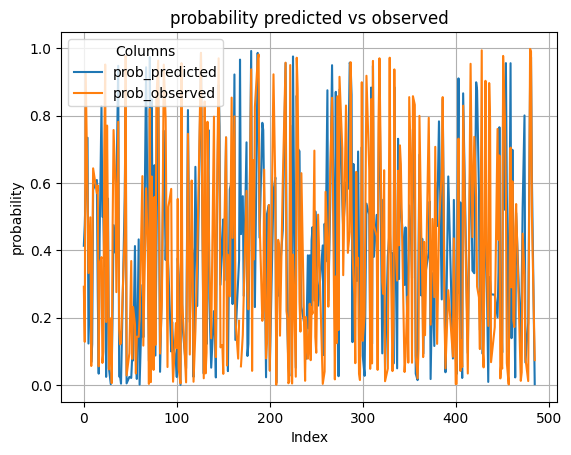

In [247]:

import pandas as pd
import matplotlib.pyplot as plt



# Plot two columns against the index
arch_0[['prob_predicted', 'prob_observed']].plot()
plt.title('probability predicted vs observed')
plt.xlabel('Index')
plt.ylabel('probability')
plt.legend(title='Columns')
plt.grid(True)
plt.show()

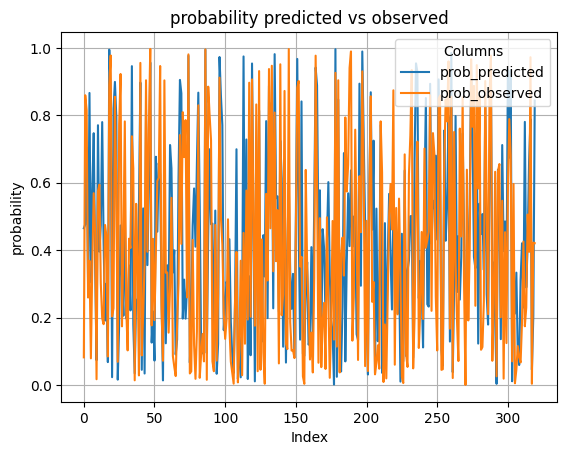

In [248]:
# example of plot from chat gpt 
import pandas as pd
import matplotlib.pyplot as plt



# Plot two columns against the index
arch_0_improved[['prob_predicted', 'prob_observed']].plot()
plt.title('probability predicted vs observed')
plt.xlabel('Index')
plt.ylabel('probability')
plt.legend(title='Columns')
plt.grid(True)
plt.show()

In [249]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [250]:
# Assuming 'test_model1' and 'test_model2' are dataframes with predicted and observed probabilities
def evaluate_model(test_data, model_name):
    test_data['prob_observed'] = pd.to_numeric(test_data['prob_observed'], errors='coerce')
    test_data['prob_predicted'] = pd.to_numeric(test_data['prob_predicted'], errors='coerce')

    y_true = test_data['prob_observed']
    y_pred = test_data['prob_predicted']

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Pearson Correlation: {pearson_corr:.4f}")
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    return mse, mae, pearson_corr, spearman_corr

In [251]:
arch_0.loc[:,'prob_observed'] = pd.to_numeric(arch_0['prob_observed'], errors='coerce')
arch_0.loc[:,'prob_predicted'] = pd.to_numeric(arch_0['prob_predicted'], errors='coerce')
y_true = arch_0['prob_observed'].to_numpy()
y_pred = arch_0['prob_predicted'].to_numpy()

In [252]:
y_true

array([0.2920209444719723, 0.12854769376639963, 0.9295286354020702,
       0.5686830639313651, 0.33272955895350326, 0.49812431747761854,
       0.056859281734731836, 0.3103398990818331, 0.6434732354622258,
       0.5698306824012314, 0.5927826938028316, 0.055953006608661676,
       0.3596965126721419, 0.3799085323635768, 0.06595099023455325,
       0.09954173408336889, 0.6962094536367972, 0.9515239079182544,
       0.18741614952048824, 0.7703479900054965, 0.45500050415055676,
       0.046673342023568716, 0.1983135583442007, 0.006049712820110105,
       0.4754467388773786, 0.7572044506495965, 0.5939030811540948,
       0.27599176988584984, 0.7814986036251161, 0.16612586772488958,
       0.12096988006315681, 0.12483265088678387, 0.4488703549496504,
       0.9773401514418653, 0.02901582737089708, 0.09481842599342012,
       0.36838632038168434, 0.07799241732969439, 0.23201571662426634,
       0.18106042164997868, 0.034550554072679734, 0.14371115107620186,
       0.14343082653054146, 0.1965

In [253]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
pearson_corr, _ = pearsonr(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)

ValueError: Input contains NaN.

In [256]:
arch_0=arch_0[arch_0["prob_observed"].notna()]

In [257]:
arch_0.dtypes

location            int64
prob_predicted    float64
prob_observed     float64
dtype: object

In [258]:
# Replace with your test data for both models
evaluate_model(arch_0, "arch_0_logit_1")

arch_0_logit_1 Evaluation:
Mean Squared Error: 0.0575
Mean Absolute Error: 0.1873
Pearson Correlation: 0.6747
Spearman Correlation: 0.6558


C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_20524\1842316770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prob_observed'] = pd.to_numeric(test_data['prob_observed'], errors='coerce')
C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_20524\1842316770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prob_predicted'] = pd.to_numeric(test_data['prob_predicted'], errors='coerce')


(np.float64(0.05745230384419164),
 np.float64(0.18734184317724098),
 np.float64(0.6746841814291238),
 np.float64(0.6558095336185197))

In [255]:
evaluate_model(arch_0_improved, "arch_0_logit_2")

arch_0_logit_2 Evaluation:
Mean Squared Error: 0.0636
Mean Absolute Error: 0.1992
Pearson Correlation: 0.6403
Spearman Correlation: 0.6299


(np.float64(0.06359906101583408),
 np.float64(0.19917269510194094),
 np.float64(0.6403217019556152),
 np.float64(0.6299215467587177))

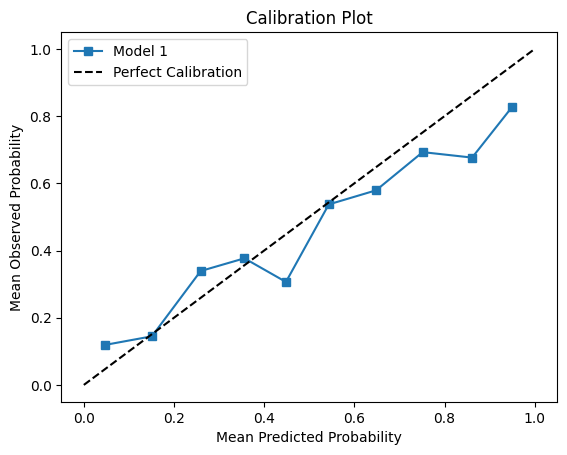

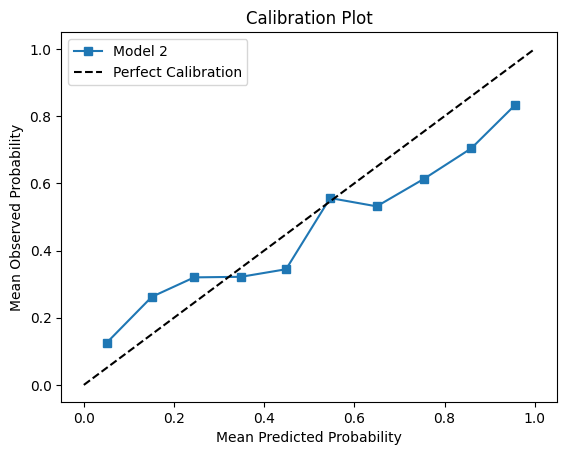

In [ ]:
# Calibration Plot
def calibration_plot(test_data, model_name):
    test_data.loc[:,'prob_observed'] = pd.to_numeric(test_data['prob_observed'], errors='coerce')
    test_data.loc[:,'prob_predicted'] = pd.to_numeric(test_data['prob_predicted'], errors='coerce')
    bins = np.linspace(0, 1, 11)
    test_data.loc[:,'bin'] = pd.cut(test_data['prob_predicted'], bins)
    grouped = test_data.groupby('bin',observed=False).mean()
    
    plt.plot(grouped['prob_predicted'], grouped['prob_observed'], "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Mean Observed Probability")
    plt.legend()
    plt.title("Calibration Plot")
    plt.show()

calibration_plot(arch_0, "Model 1")
calibration_plot(arch_0_improved, "Model 2")

### Results for archetype 1

In [ ]:
arch_1=final_test["archetype_1"]
arch_1_improved=final_test_improved["archetype_1"]

In [ ]:
def drop_nan(test_data):
    initial_rows=test_data.shape[0]
    data_cleaned=test_data.dropna()
    data_cleaned=data_cleaned[data_cleaned["prob_predicted"]!=1]
    final_rows=data_cleaned.shape[0]
    rows_removed=initial_rows - final_rows
    print(f"{rows_removed} rows were removed")
    return data_cleaned

In [ ]:
arch_1=drop_nan(arch_1)
arch_1_improved=drop_nan(arch_1_improved)

170 rows were removed
0 rows were removed


In [ ]:
evaluate_model(arch_1, "arch_1_logit_1")
evaluate_model(arch_1_improved, "arch_1_logit_2")

arch_1_logit_1 Evaluation:
Mean Squared Error: 0.0576
Mean Absolute Error: 0.1878
Pearson Correlation: 0.6680
Spearman Correlation: 0.6514
arch_1_logit_2 Evaluation:
Mean Squared Error: 0.0624
Mean Absolute Error: 0.1981
Pearson Correlation: 0.6362
Spearman Correlation: 0.6229


(np.float64(0.06243659861160874),
 np.float64(0.19813243415699175),
 np.float64(0.636182198368014),
 np.float64(0.6229036620447671))

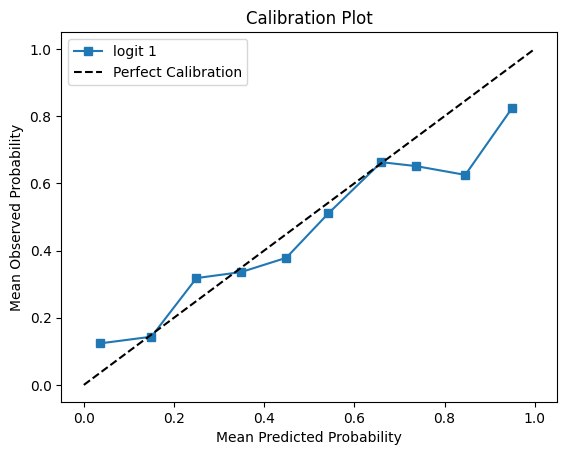

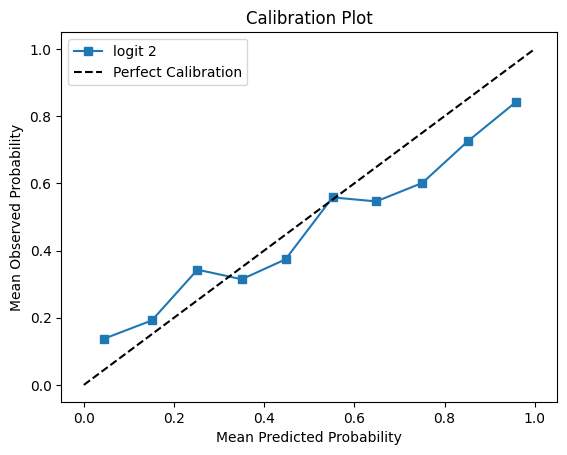

In [ ]:
calibration_plot(arch_1, "logit 1")
calibration_plot(arch_1_improved, "logit 2")

### Results for archetype 2

In [ ]:
arch_2=final_test["archetype_2"]
arch_2_improved=final_test_improved["archetype_2"]

In [ ]:
arch_2=drop_nan(arch_2)
arch_2_improved=drop_nan(arch_2_improved)

170 rows were removed
0 rows were removed


In [ ]:
evaluate_model(arch_2, "arch_2_logit_1")
evaluate_model(arch_2_improved, "arch_2_logit_2")

arch_2_logit_1 Evaluation:
Mean Squared Error: 0.0577
Mean Absolute Error: 0.1886
Pearson Correlation: 0.6660
Spearman Correlation: 0.6492
arch_2_logit_2 Evaluation:
Mean Squared Error: 0.0621
Mean Absolute Error: 0.1976
Pearson Correlation: 0.6386
Spearman Correlation: 0.6247


(np.float64(0.06212752812786302),
 np.float64(0.19764487653659507),
 np.float64(0.6386477963722343),
 np.float64(0.6246900566067008))

C:\Users\LMENENDEZ\AppData\Local\Temp\ipykernel_2444\4228128642.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:,'bin'] = pd.cut(test_data['prob_predicted'], bins)


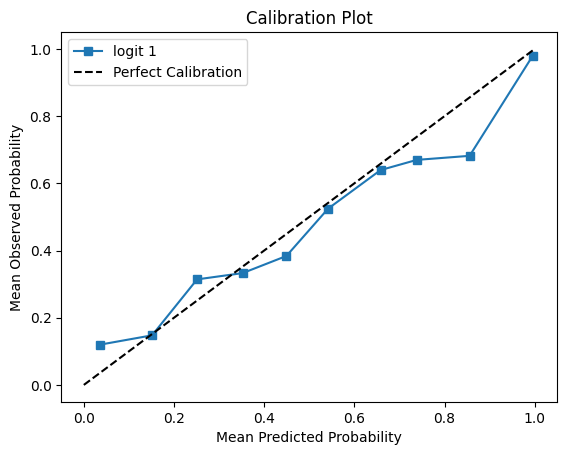

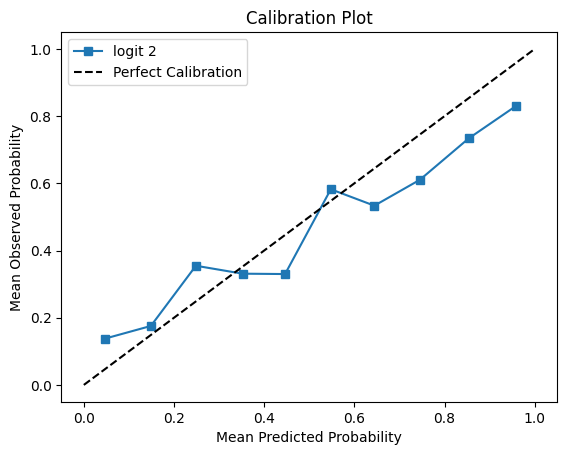

In [ ]:
calibration_plot(arch_2, "logit 1")
calibration_plot(arch_2_improved, "logit 2")

### Results for archetype 3

In [ ]:
arch_3=final_test["archetype_3"]
arch_3_improved=final_test_improved["archetype_3"]

In [ ]:
arch_3=drop_nan(arch_3)
arch_3_improved=drop_nan(arch_3_improved)

170 rows were removed
0 rows were removed


In [ ]:
# evaluate_model(arch_3, "arch_3_logit_1")
evaluate_model(arch_3_improved, "arch_3_logit_2")

arch_3_logit_2 Evaluation:
Mean Squared Error: 0.0615
Mean Absolute Error: 0.1969
Pearson Correlation: 0.6431
Spearman Correlation: 0.6284


(np.float64(0.06147456602159288),
 np.float64(0.19692360197406472),
 np.float64(0.6431330576439529),
 np.float64(0.628354765581951))

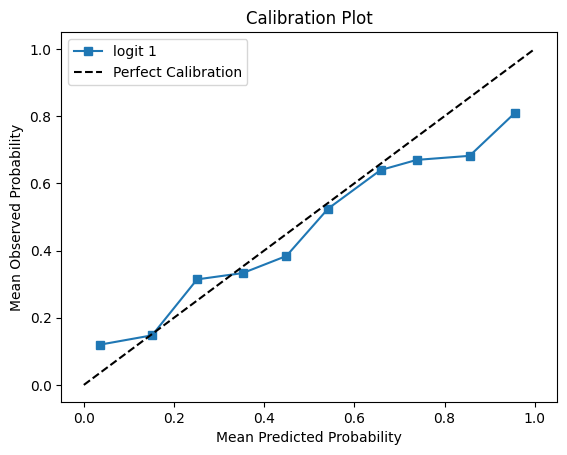

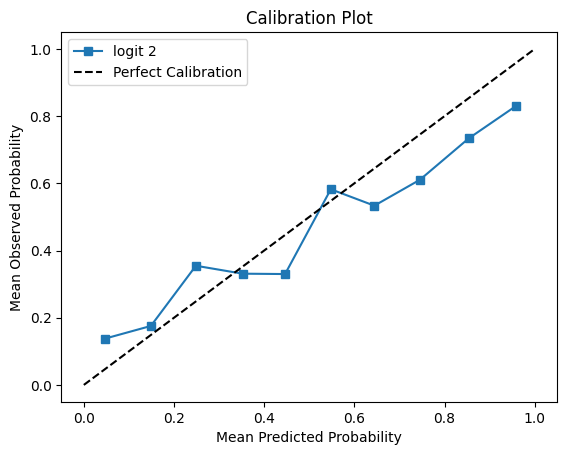

In [ ]:
calibration_plot(arch_2, "logit 1")
calibration_plot(arch_2_improved, "logit 2")

### Results for archetype 4

In [ ]:
arch_4=final_test["archetype_4"]
arch_4_improved=final_test_improved["archetype_4"]

In [ ]:
arch_4=drop_nan(arch_4)
arch_4_improved=drop_nan(arch_4_improved)

170 rows were removed
0 rows were removed


In [ ]:
evaluate_model(arch_4, "arch_4_logit_1")
evaluate_model(arch_2_improved, "arch_4_logit_2")

arch_4_logit_1 Evaluation:
Mean Squared Error: 0.0564
Mean Absolute Error: 0.1849
Pearson Correlation: 0.6744
Spearman Correlation: 0.6537
arch_4_logit_2 Evaluation:
Mean Squared Error: 0.0621
Mean Absolute Error: 0.1976
Pearson Correlation: 0.6386
Spearman Correlation: 0.6247


(np.float64(0.06212752812786302),
 np.float64(0.19764487653659507),
 np.float64(0.6386477963722343),
 np.float64(0.6246900566067008))

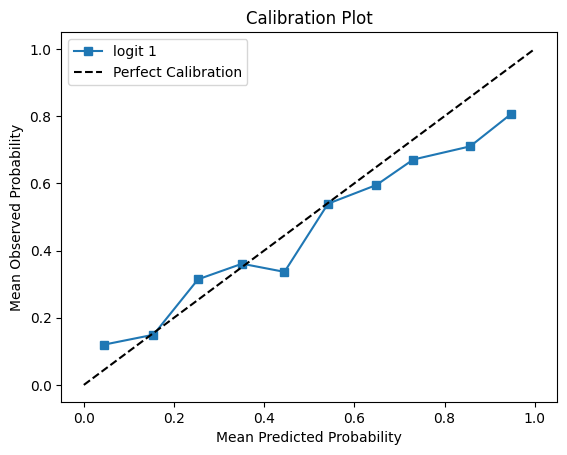

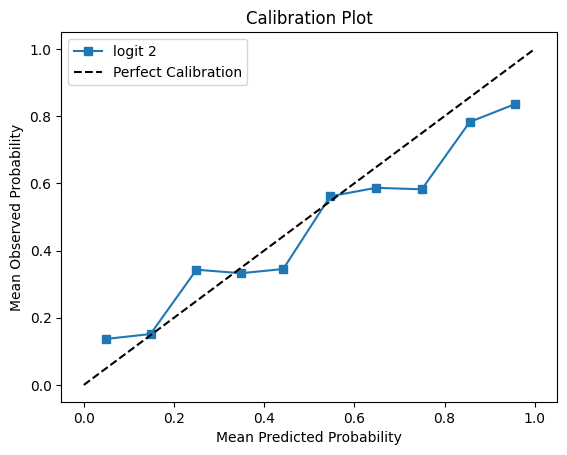

In [ ]:
calibration_plot(arch_4, "logit 1")
calibration_plot(arch_4_improved, "logit 2")

### Results for archetype 5

In [ ]:
arch_5=final_test["archetype_5"]
arch_5_improved=final_test_improved["archetype_5"]

In [ ]:
arch_5=drop_nan(arch_5)
arch_5_improved=drop_nan(arch_5_improved)

170 rows were removed
0 rows were removed


In [ ]:
evaluate_model(arch_5, "arch_5_logit_1")
evaluate_model(arch_5_improved, "arch_5_logit_2")

arch_5_logit_1 Evaluation:
Mean Squared Error: 0.0570
Mean Absolute Error: 0.1867
Pearson Correlation: 0.6722
Spearman Correlation: 0.6538
arch_5_logit_2 Evaluation:
Mean Squared Error: 0.0619
Mean Absolute Error: 0.1976
Pearson Correlation: 0.6390
Spearman Correlation: 0.6252


(np.float64(0.0619366995593718),
 np.float64(0.19764852373083783),
 np.float64(0.6390491479614723),
 np.float64(0.6252152655083284))

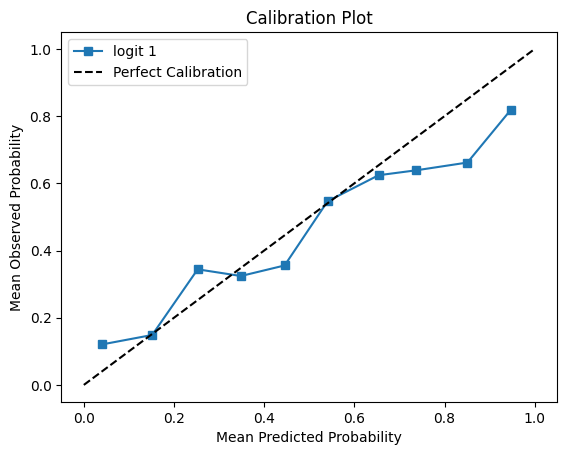

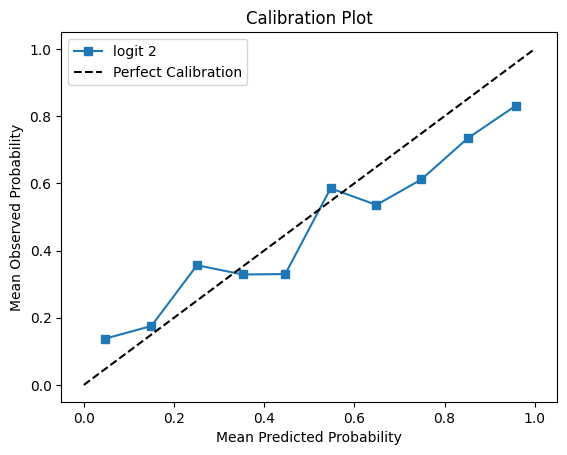

In [ ]:
calibration_plot(arch_5, "logit 1")
calibration_plot(arch_5_improved, "logit 2")